# Open Food Facts

## Context

[Open Food Facts](https://www.kaggle.com/openfoodfacts/world-food-facts/home) is a free, open, collbarative database of food products from around the world, with ingredients, allergens, nutrition facts and all the tidbits of information we can find on product labels.

Open Food Facts is a non-profit association of volunteers. 5000+ contributors like you have added 600 000+ products from 150 countries using our Android, iPhone or Windows Phone app or their camera to scan barcodes and upload pictures of products and their labels.

Data about food is of public interest and has to be open.  
**The complete database is published as open data and can be reused by anyone and for any use.**

# A. Importing and cleaning the data

In [1]:
import random
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(style='white')

## A.1 Importing the Dataset

Because the dataset is large, about 1 Go, it is not provided in the Github repository but can be downloaded at this URL : https://www.kaggle.com/openfoodfacts/world-food-facts

The dataset is a `.tsv` file that stands for tabulation-separated values, an open text format.

In [2]:
# load the .tsv file by specifying the tab separator and to not load the file by chunks (avoid mixed type inference)
filename = 'en.openfoodfacts.org.products.tsv'
data = pd.read_table(filename, sep='\t', low_memory=False)

In [3]:
# get some info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356027 entries, 0 to 356026
Columns: 163 entries, code to water-hardness_100g
dtypes: float64(107), object(56)
memory usage: 442.8+ MB


It's a big dataset, we have about 360k observations, 56 object variables and 107 numerical variables.  
Note that the result of the `info()` method is truncated because the size of the dataset.

## A.2 Basic Safe Cleaning

We can safely remove observations and variables with no data and duplicates if any:

In [4]:
nrows, ncols = data.shape

# Drop observations with no data (safe cleaning)
data.dropna(how='all', inplace=True)

# Drop variables with no data (safe cleaning)
empty_variables = data.columns[data.isnull().sum() == data.shape[0]]
data.dropna(how='all', axis=1, inplace=True)

# Remove duplicates observations
duplicates_count = data.duplicated().sum()
data.drop_duplicates(inplace=True)

print('Number of empty observations dropped: {}'.format(nrows - data.shape[0]))
print('Number of empty variables dropped: {}'.format(len(empty_variables)))
print('Variables dropped:\n{}'.format(empty_variables))
print('Number of duplicates dropped: {}'.format(duplicates_count))
print('\nDataset dimensions: {}'.format(data.shape))

Number of empty observations dropped: 0
Number of empty variables dropped: 16
Variables dropped:
Index(['no_nutriments', 'ingredients_from_palm_oil',
       'ingredients_that_may_be_from_palm_oil', 'nutrition_grade_uk',
       '-butyric-acid_100g', '-caproic-acid_100g', '-lignoceric-acid_100g',
       '-cerotic-acid_100g', '-melissic-acid_100g', '-elaidic-acid_100g',
       '-mead-acid_100g', '-erucic-acid_100g', '-nervonic-acid_100g',
       'chlorophyl_100g', 'glycemic-index_100g', 'water-hardness_100g'],
      dtype='object')
Number of duplicates dropped: 0

Dataset dimensions: (356027, 147)


There was 16 variables with only NaN values.

## A.3 Variables Identification

Let's have a better overview of the dataset. Because there are a lot of variables, we will treat the object and numerical variables separately

In [5]:
# Increase the default number of rows displayed by pandas before truncation
pd.set_option('max_rows', 100)

# Get summary for object variables only
data.describe(include='object').T

,count,unique,top,freq
code,356001,356001,0049705683040,1
url,356001,356001,http://world-en.openfoodfacts.org/product/0071...,1
creator,356024,3890,usda-ndb-import,169868
created_t,356024,224751,1489077120,20
created_datetime,356017,224752,2017-03-09T10:37:09Z,20
last_modified_t,356027,216836,1439141742,30
last_modified_datetime,356027,216836,2015-08-09T17:35:42Z,30
product_name,338515,249245,Ice Cream,411
generic_name,57714,42451,Pâtes alimentaires au blé dur de qualité supér...,201
quantity,119285,15563,500 g,5285


We can already say that :

- Remember we have 356'027 observations, so it means that we have a lot of missing values in our data
- The `code` (barcode) or `url` variables can be used as our *unique key/index*. We also need to drop the observations with missing `code`
- The most frequent `creator` is *usda-ndb-import*. This dataset is probably an aggreation of multiple data sources with their own structure that could explain why the dataset looks very sparse
- We have some time information. `created_datetime` and `last_modified_datetime` must be converted from `object` to `datetime` type 
- Variables are often declined in three versions: `x`, `x_tags` and `x_en`. `x_tags` looks the easiest to manipulate with code. Note the `en:` prefix; it means we have probably multiple langages in the data
- The `states` variables give some information about the completion status of each observation

We can also identify some themes :

- Origin, Brands, Labels, Countries
- Packaging, Emb code, Manufacturing places
- Ingredients, Allergens, Traces, Additives
- Palm oil

And some interesting classification variables :

- `categories`, `main_category`
- `pnns_groups`
- `nutrition_grade` (could be a target variable to build a model)

Let's clean the data as stated above (we stay very conservative) :

In [6]:
# Define variables subset in which we don't want missing data
subset = [
    'code',
    'creator',
    'created_datetime',
    'last_modified_datetime',
    'states_tags'
]

# Drop observations with missing data in this subset
data.dropna(subset=subset, inplace=True)

# Drop the new variables with missing data that appear after the previous drop
data.dropna(how='all', axis=1, inplace=True)

print('Dataset shape: {}'.format(data.shape))

Dataset shape: (355971, 142)


Note that we have dropped 56 observations and 5 variables also.

In [7]:
# Set the code as the index
data.set_index('code', inplace=True)

We must now convert the `created_datetime` and `last_modified_datetime` variables to datetime64 type :

In [8]:
# Convert the created_datetime & last_modified_datetime object variables to datetime variables
data.created_datetime = pd.to_datetime(data.created_datetime)
data.last_modified_datetime = pd.to_datetime(data.last_modified_datetime)

data.created_datetime.head()

code
0000000003087   2016-09-17 09:17:46
0000000004530   2017-03-09 14:32:37
0000000004559   2017-03-09 14:32:37
0000000016087   2017-03-09 10:35:31
0000000016094   2017-03-09 10:34:13
Name: created_datetime, dtype: datetime64[ns]

It's time now to look at the numerical variables :

In [9]:
# Get summary for numerical variables only
data.describe(include='number').T

,count,mean,std,min,25%,50%,75%,max
additives_n,283865.0,1.876857,2.501028e+00,0.000000,0.000000e+00,1.000000,3.000000,3.000000e+01
ingredients_from_palm_oil_n,283865.0,0.023430,1.530943e-01,0.000000,0.000000e+00,0.000000,0.000000,2.000000e+00
ingredients_that_may_be_from_palm_oil_n,283865.0,0.059736,2.806605e-01,0.000000,0.000000e+00,0.000000,0.000000,6.000000e+00
energy_100g,295365.0,1125.452006,9.368289e+02,0.000000,3.820000e+02,1092.000000,1674.000000,2.311990e+05
energy-from-fat_100g,869.0,587.216617,7.132557e+02,0.000000,4.940000e+01,300.000000,900.000000,3.830000e+03
fat_100g,279495.0,56066.272868,2.963395e+07,0.000000,1.000000e-01,5.290000,20.000000,1.566667e+10
saturated-fat_100g,263821.0,5.092425,7.965127e+00,0.000000,0.000000e+00,1.790000,7.140000,5.500000e+02
-caprylic-acid_100g,1.0,7.400000,NaN,7.400000,7.400000e+00,7.400000,7.400000,7.400000e+00
-capric-acid_100g,2.0,6.040000,2.262742e-01,5.880000,5.960000e+00,6.040000,6.120000,6.200000e+00
-lauric-acid_100g,4.0,36.136182,2.410143e+01,0.044730,3.466118e+01,47.600000,49.075000,4.930000e+01


Globally, we have facts for:

- Macronutrients with their multiple breakdowns levels: carbohydrates, fats, proteins   
- Micronutrients: minerals, vitamins
- Energy and nutrition score that could be used as target variables to build a model

We can also say that :

- We have very few data for the "leaf" and "intermediate" breakdown levels. We could probably safely drop all these variables (see missing values section below)
- Data are normalized on 100 grams. There are some negatives values and values greater than 100 to clean
- The nutrition score range from -15 to 40 (it looks weird but it's right... see last section)
- Energy is express in kilojoules.

Let's do some cleaning :

We will drop observations with incoherent values. We could decide to replace negative values by 0 but given the nature of the project in which everyone can contribute, observations with incoherent data are probably bad entries (and we have also more than enough data).

In [10]:
# Drop observations with facts that have negative values
obs_with_negative_facts = (data.loc[:, 'fat_100g':'cocoa_100g'] < 0).any(axis=1)
data.drop(data[obs_with_negative_facts].index, inplace=True)

# Drop observations with facts that have value greater than 100g
obs_with_facts_gt_100 = (data.loc[:, 'fat_100g':'cocoa_100g'] > 100).any(axis=1)
data.drop(data[obs_with_facts_gt_100].index, inplace=True)


print('Facts min value: {}'.format(data.describe(include='number').T.loc['fat_100g':'cocoa_100g', 'min'].min()))
print('Facts max value: {}'.format(data.describe(include='number').T.loc['fat_100g':'cocoa_100g', 'max'].max()))
print('Dataset shape: {}'.format(data.shape))


Facts min value: 0.0
Facts max value: 100.0
Dataset shape: (355708, 141)


In the process, we have dropped 263 observations.  

## A.4 Missing Values

Let's speak now about the missing values, the dataset is very sparse but let's just have a better overview of it by plotting an histrogram of the percentage of missing values per variables, stacked by type (object and number) and also an histrogram of the percentage of missing values per observation :

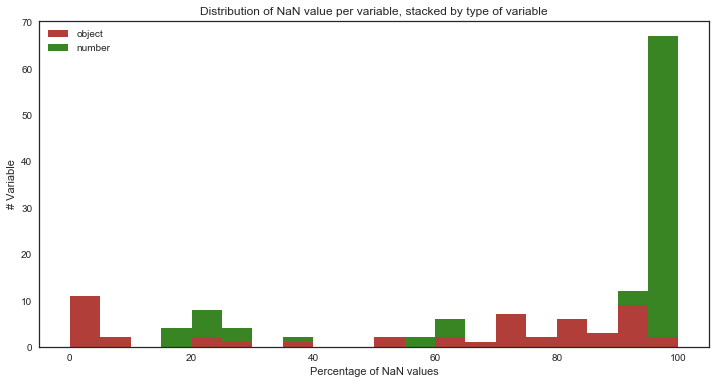

In [11]:
# Distribution of missing values per variable, stacked by type of variable
nan_counts_object_vars = data.select_dtypes('object').isnull().sum() / data.shape[0] * 100
nan_counts_number_vars = data.select_dtypes('number').isnull().sum() / data.shape[0] * 100

pd.DataFrame({'object': nan_counts_object_vars, 'number': nan_counts_number_vars}) \
  .plot.hist(stacked=True, bins=20, figsize=(12, 6), color=['#B13E38', '#398524'])

plt.xlabel('Percentage of NaN values')
plt.ylabel('# Variable')
plt.title('Distribution of NaN value per variable, stacked by type of variable')
plt.show()

It is clear that we have variables with essentially missing values but we need to ask what does it mean to have missing values in an object variable and a numerical variable from the *domain* point of view:

- object variables are essentielly data that describe the products or allow to classify them. At high level, missing values mean incomplete product sheet. For exemple, if we are interested by pnns groups, we will work at best with about 1/3 of the dataset.

- most of the numerical variables are food facts. Some facts are just less current than others; if it's almost impossible to find in our fridge a product without indication about the fats, it will be harder to find one with iron for example. Because the dataset shows the food facts in an unstacked form, we have very sparse data. In this case, variables with a lot of missing values doesn't mean poor variables but in fact even the opposite. If we wanted to analyze baby foods at different ages, these rare facts/variables would be probably very usefull.

Finally, dropping variables should be driven by the analysis we want to lead. Personnaly, I prefer to drop no variables at all, or use a simple NaN threshold rule even if in the rest of this course project we could do it safely. We have a big dataset, but it could be a lot bigger. In the rest of the project, we will build subset dataframe with data we need to lead our analysis. I prefer the strategy to build a new dataframe from the source than reducing the source dataframe shape.

Note that even 5% of non null values in a variable represent about 18'000 observations, more than enough if we ask a statistician :)

In [12]:
# Here is an utility function to facilitate the exploration : 
# Get variables for which the percentage of missing values is in the low%, high% range
def get_variables_with_nan_in_range(data, low, high, dtypes):
    if high >= 100:
        high = 100.1
        
    nan_counts = data.select_dtypes(dtypes).isnull().sum()    
    nan_counts_percent = nan_counts / data.shape[0] * 100
    
    filter = (nan_counts_percent >= low) & (nan_counts_percent < high)
    nan_counts = nan_counts[filter]
    nan_counts_percent = nan_counts_percent[filter]
    counts = data.shape[0] - nan_counts
    counts_percent = 100 - nan_counts_percent
    
    return pd.DataFrame({
        'counts': counts, 
        'counts %': counts_percent, 
        'nan counts': nan_counts, 
        'nan counts %': nan_counts_percent})

# Food facts with NaN
get_variables_with_nan_in_range(data, 0, 95, 'number')

,counts,counts %,nan counts,nan counts %
additives_n,283624,79.735064,72084,20.264936
ingredients_from_palm_oil_n,283624,79.735064,72084,20.264936
ingredients_that_may_be_from_palm_oil_n,283624,79.735064,72084,20.264936
energy_100g,295108,82.963554,60600,17.036446
fat_100g,279245,78.503998,76463,21.496002
saturated-fat_100g,263677,74.127374,92031,25.872626
monounsaturated-fat_100g,23025,6.473006,332683,93.526994
polyunsaturated-fat_100g,23060,6.482845,332648,93.517155
trans-fat_100g,143342,40.297660,212366,59.702340
cholesterol_100g,144073,40.503166,211635,59.496834


In the range 0-95% of missing values, we have variables for macronutrients and the fats first breakdown level and the most current minerals and vitamins. We are missing starch, polyols for the first carbohydrates breakdown level; casein and serum-proteins for proteins.

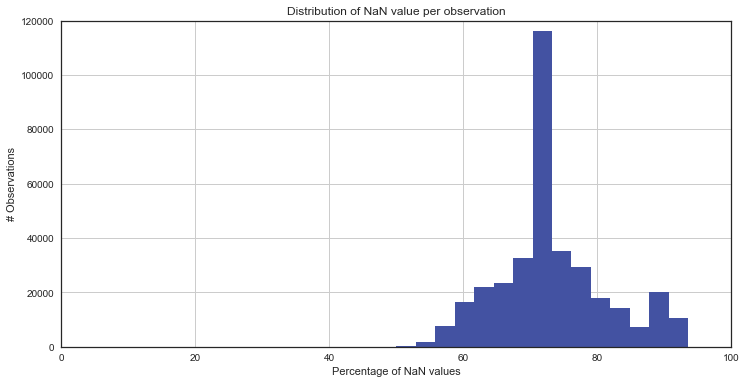

In [13]:
# Distribution of missing values per observation
nan_counts_obs = data.isnull().sum(axis=1) / data.shape[1] * 100
nan_counts_obs.hist(bins=20, figsize=(12, 6), color=['#4352a2'])

plt.xlim((0, 100))
plt.ylim((0, 120000))
plt.xlabel('Percentage of NaN values')
plt.ylabel('# Observations')
plt.title('Distribution of NaN value per observation')
plt.show()

Concerning missing values per observation, it is interesting to see this huge spike around 70% missing values. It is probably caused by the usda ndb import that represent about half of the dataset. It reflects the usda database structure, maybe...

## A.5 Summary 
In summary, in this first part, we have acquire a better understanding of the data and its structure. We have done some safely and basic cleaning. We decided to keep all variables with data because in the next sections, we will build dedicated subset dataframes to lead our different analysis. 

At this stage, we have a source dataframe we are confident to work with. Of course, it was only a first cleaning iteration and we will have to clean the data in more depth in the next sections.

# B. Manipulating the data

In this section, we will work with the data and investigate on three different topics:

1. Everytime we ask the data, they answer. Without no knowledge about the origin of the data, how they have been collected, where do they come from, the answers could be biased and we would have no way of guessing it. In this first topic, we will work with the `creator`, `created_datetime` and `states_tags` to get a better understanding of the data. We will also see if the openfoodfact project is a living project. It will not be the sexiest part, but there will be some interesting data manipulation in the process.

2. More funny, we will invistigate about the allergens and try to know which allergens are the most common. Because the data contains multiple langages, we will first build a dictonnary to translate allergens, a good opportunity to practice web scrapping, string manipulation and cleaning because the allergens data are messy

3. Finally, we will also work with numerical data. We will investigate about the macronutrient breakdown across the different category of foods (`pnns_groups`) and answer which are the foods that have the highest ratio of fibers. It will be also an opportunity to use some statistical methods to determine if our results are significant or due to chance. We will also try to build a "model" that could predict the energy from the macronutrients breakdown.

Along the rest of the project, we will use some utility functions, here there are :

In [14]:
# Utility function: 
# Get the top occurencies 
def get_top_occurencies(df, cols, n=10):
    count = df.groupby(cols).size().sort_values(ascending=False)
    count_percent = round(count / df.shape[0] * 100, 2)
    return pd.DataFrame({'count': count, 'count %': count_percent}).head(n)

# Utility function: 
# Get the top occurencies containing a regexp/string
def get_top_occurencies_containing(df, col, value, n=10):
    occurences = get_top_occurencies(df, col, df.shape[0])
    return occurences[occurences.index.str.contains(r'{}'.format(value))].head(n)

## B.1 Domain and Data Source Knowledge

### Data Sources and Collection of Data

Where the data come from and how they have been collected are the questions we want to answer in this section. At the end the goal is to have a critical mind about the results we will obtain. (I am more worried about Artificial Stupidity than Artificial Intelligence in the future :)

Example: We have data coming from multiple supermarket inventories VS we have products collected by people by their own motivations (with a mobile app). In the first case, we would have all sort of products and if the supermarkets are not specific food supermarket (bio food only for example), data should not be biased. In the second case, where the collection is the result of the people motivation, it becomes more probable to have biased data. Who are interesting about the food facts, why and which products they would tend to buy and scan ? Probably the people in the diet, sportsmen/women etc and their choice of foods will reflect it and our dataset also... We get the idea and we want to be sure it is not the case with our data !

Let's see what we can learn from the `creator` variable :

In [15]:
# Get the top contributors
get_top_occurencies(data, 'creator', n=10)

,count,count %
creator,,
usda-ndb-import,169662,47.70
openfoodfacts-contributors,45785,12.87
kiliweb,36369,10.22
date-limite-app,12678,3.56
openfood-ch-import,11466,3.22
tacite,7913,2.22
sebleouf,6443,1.81
tacinte,4808,1.35
javichu,2768,0.78


We see that half of the data come from the import of the [U.S Department of Agriculture National Nutrients Database for branded foods](https://ndb.nal.usda.gov/ndb/). Morever, we have also data imported from The Food Repo (openfood.ch), a project initiated by the Digital Epidemiology Lab of EPFL.

Some web reasearch allows us to tell that:

- openfoodfacts-contributors are anonymous OpenFoodFacts contributors
- kiliweb is a french startup who develop the Yuka app that implements the OpenFoodFacts API
- date-limite-app is also a mobile app that implement the OpenFoodFacts API
- other contributors are registred contributors (Stephane is probably the OpenFoodFacts founder)

It also means that our data distribution (missing and non-missing values) will probably reflect the structure of the USDA database. Morever, we will probably observe that most of the products come from the US, France and Swizerland (US database, Yuka and OpenFoodFacts are french projects, the FoodRepo is a swiss project.

Concerning the way the data are collected:

- USDA NDB data are provided by food manufacturers and the database is maintained by the USDA who standardize and normalize the data. With data coming from the US, we need to take care about the units
- The Food Repo data are collected by volunteers when distributors give access to their stores. The communauty can improve the data from the website by answering questions about missing data (always weight/volume)
- OpenFoodFacts data are collected from the mobile app that can only send photos but not create/edit food facts. The website allows to edit foodfacts but only if registred.

Because of the two-steps process, we have probably a lot of observations without facts (people that use the app, takes pictures but never fill the product sheet from the website).

Note:
It seems that OpenFoodFacts do not use yet OCR or more advance technologies (deep learning, neuronal network) to automate the process from the picture of ingredients and facts but project to do it are in progress.


To answer our bias concern, our data come from shop inventories, manufacturer initiatives and products scanned by people. The drawback we could have is bias from countries because at this stage, it seems probable that half of our data are US products.

Let's first engineer a `source` variable from the `creator` one and check if our supposition about the countries is right.

In [16]:
# Check if there are other data from external databases
get_top_occurencies_containing(data, 'creator', value='import|load|dump|database|db|\-', n=20)

,count,count %
creator,,
usda-ndb-import,169662,47.70
openfoodfacts-contributors,45785,12.87
date-limite-app,12678,3.56
openfood-ch-import,11466,3.22
big-brother,224,0.06
julie-yuka,186,0.05
esencia-andalusi,94,0.03
canieatthis-app,92,0.03
tib-de-bar,82,0.02


Visibly there are no other external datasources. Let's create a `source` variable, with this mapping:  
(mobile apps that implement the openfoodfacts API can ben considered as openfoodfacts contributors)

- usda-ndb-import => usda
- openfood-ch-import => foodrepo
- all others => openfoodfacts

In [17]:
# Create a source variable from the following mapping
mapping = {
    'usda-ndb-import': 'usda',
    'openfood-ch-import': 'foodrepo'
}
data['source'] = data.creator.map(mapping)
data['source'].fillna(value='openfoodfacts', inplace=True)

get_top_occurencies(data, 'source')

,count,count %
source,,
openfoodfacts,174580,49.08
usda,169662,47.70
foodrepo,11466,3.22


Let's confirm our intuition about the countries distribution per source 

In [18]:
# More common countries grouped by source
get_top_occurencies(data, ['source', 'countries'], n=10)

count  count %
source        countries                      
usda          US              169470    47.64
openfoodfacts France          106261    29.87
              en:FR            16056     4.51
foodrepo      Suisse           10823     3.04
openfoodfacts Deutschland       6896     1.94
              España            3896     1.10
              United Kingdom    3360     0.94
              United States     2233     0.63
              en:CH             2206     0.62
              en:BE             1759     0.49

We need to keep in mind this fact for the rest of the project. It can be an issue or not because with data sources aggregation there is always a drawback: the data sources don't have necesserly the same structure and so have missing values in differents variables (remember the huge spike in the last plot ?). 

Example: We want to analyze allergens but because USDA database do not provides allergens, we will just have no observations coming from this data source (and only products from openfoodfacts and foodrepo, so from France and Switzerland essentially).

Let's get an idea about which information we can get from the different data sources with the help of the `states_tags` variable.

### Data Source Structures and States of the Observations 

The `states_tags` variable provides status about each observation and could be a good way to reduce the size of our data set according to our needs for the futur analysis. In this section, we will:

- Create indicator variables for each completed states
- Analyze if each data source tend to provide data for all variables or only a part of them and in which proportion

In [19]:
# Get some examples of states_tags values
get_top_occurencies(data, 'states_tags', 5)

,count,count %
states_tags,,
"en:to-be-completed,en:nutrition-facts-completed,en:ingredients-completed,en:expiration-date-to-be-completed,en:packaging-code-to-be-completed,en:characteristics-to-be-completed,en:categories-to-be-completed,en:brands-completed,en:packaging-to-be-completed,en:quantity-to-be-completed,en:product-name-completed,en:photos-to-be-uploaded",167658,47.13
"en:to-be-checked,en:complete,en:nutrition-facts-completed,en:ingredients-completed,en:expiration-date-completed,en:characteristics-completed,en:categories-completed,en:brands-completed,en:packaging-completed,en:quantity-completed,en:product-name-completed,en:photos-validated,en:photos-uploaded",20759,5.84
"en:to-be-checked,en:complete,en:nutrition-facts-completed,en:ingredients-completed,en:expiration-date-to-be-completed,en:characteristics-completed,en:categories-completed,en:brands-completed,en:packaging-completed,en:quantity-completed,en:product-name-completed,en:photos-validated,en:photos-uploaded",17093,4.81
"en:to-be-completed,en:nutrition-facts-completed,en:ingredients-completed,en:expiration-date-to-be-completed,en:packaging-code-to-be-completed,en:characteristics-to-be-completed,en:categories-to-be-completed,en:brands-completed,en:packaging-to-be-completed,en:quantity-to-be-completed,en:product-name-completed,en:photos-to-be-validated,en:photos-uploaded",13432,3.78
"en:to-be-checked,en:complete,en:nutrition-facts-completed,en:ingredients-completed,en:expiration-date-completed,en:packaging-code-to-be-completed,en:characteristics-completed,en:categories-completed,en:brands-completed,en:packaging-completed,en:quantity-completed,en:product-name-completed,en:photos-validated,en:photos-uploaded",12013,3.38


We want to build a DataFrame with each completed states as indicator variables, so we need to:

1. extract all states for each observation (states start by en: and are separated by a comma)
2. Pivot the table to have one variable per states
3. Remove variables that correspond to not completed states

In [20]:
# 1. Extract all the states (return a multi-indexed Series with extracted states as value, <code + match> | state)
# During extraction, we give the name: states to the extracted group
df_states = data.states.str.extractall(r"en:(?P<states>[^,]+)")
df_states.head()

states
code          match                                 
0000000003087 0                      to-be-completed
              1      nutrition-facts-to-be-completed
              2          ingredients-to-be-completed
              3      expiration-date-to-be-completed
              4      characteristics-to-be-completed

In [21]:
# 2. Pivot the table to have one variable for each individual state 
# (we need to reset the index and create a column value to pivot the table)
df_states.reset_index(inplace=True)
df_states['values'] = 1
df_states = df_states.pivot_table(index='code', columns='states', values='values', fill_value=0)
df_states.head()

states,brands-completed,brands-to-be-completed,categories-completed,categories-to-be-completed,characteristics-completed,characteristics-to-be-completed,complete,empty,expiration-date-completed,expiration-date-to-be-completed,...,photos-to-be-uploaded,photos-to-be-validated,photos-uploaded,photos-validated,product-name-completed,product-name-to-be-completed,quantity-completed,quantity-to-be-completed,to-be-checked,to-be-completed
code,,,,,,,,,,,,,,,,,,,,,
0000000003087,1,0,0,1,0,1,0,0,0,1,...,0,1,1,0,1,0,1,0,0,1
0000000004530,0,1,0,1,0,1,0,0,0,1,...,1,0,0,0,1,0,0,1,0,1
0000000004559,1,0,0,1,0,1,0,0,0,1,...,1,0,0,0,1,0,0,1,0,1
0000000016087,1,0,0,1,0,1,0,0,0,1,...,1,0,0,0,1,0,0,1,0,1
0000000016094,1,0,0,1,0,1,0,0,0,1,...,1,0,0,0,1,0,0,1,0,1


In [22]:
# 3. Keep only the completed states (remove the empty state and states containing to-be)
columns_to_drop = df_states.columns[df_states.columns.str.contains(r'to-be|empty')]
df_states.drop(axis=1, columns=columns_to_drop, inplace=True)
df_states.head()

states,brands-completed,categories-completed,characteristics-completed,complete,expiration-date-completed,ingredients-completed,nutrition-facts-completed,packaging-code-completed,packaging-completed,photos-uploaded,photos-validated,product-name-completed,quantity-completed
code,,,,,,,,,,,,,
0000000003087,1,0,0,0,0,0,0,0,0,1,0,1,1
0000000004530,0,0,0,0,0,1,1,0,0,0,0,1,0
0000000004559,1,0,0,0,0,1,1,0,0,0,0,1,0
0000000016087,1,0,0,0,0,1,1,0,0,0,0,1,0
0000000016094,1,0,0,0,0,1,1,0,0,0,0,1,0


**Note:**  
The method `pd.Series.str.get_dummies(sep=',')` exists for this kind of current operation. But it was a good opportunity to practice use the `pivot_table()` method.

We want now to compare the structure of each data source so let's join the source variable to the `df_states` dataframe

In [23]:
# Join the source variable
df_states = df_states.join(data.source, how='inner')

In [24]:
# Counts of observations with completed states grouped by sources
df_states.groupby(data.source).sum()

,brands-completed,categories-completed,characteristics-completed,complete,expiration-date-completed,ingredients-completed,nutrition-facts-completed,packaging-code-completed,packaging-completed,photos-uploaded,photos-validated,product-name-completed,quantity-completed
source,,,,,,,,,,,,,
foodrepo,6022,955,382,181,117,6509,9212,97,456,11466,1576,8467,4246
openfoodfacts,151861,101175,82626,67905,48442,104304,130441,12844,89413,159962,81839,160109,114900
usda,168807,1067,19,13,10,169642,169660,1,26,164,25,169617,43


In [25]:
# Proportion in % of observations with completed states by source
df_states_prop = df_states.groupby(data.source).agg(lambda x: round(x.sum() / x.shape[0] * 100,2))
df_states_prop

,brands-completed,categories-completed,characteristics-completed,complete,expiration-date-completed,ingredients-completed,nutrition-facts-completed,packaging-code-completed,packaging-completed,photos-uploaded,photos-validated,product-name-completed,quantity-completed
source,,,,,,,,,,,,,
foodrepo,52.52,8.33,3.33,1.58,1.02,56.77,80.34,0.85,3.98,100.00,13.74,73.84,37.03
openfoodfacts,86.99,57.95,47.33,38.90,27.75,59.75,74.72,7.36,51.22,91.63,46.88,91.71,65.82
usda,99.50,0.63,0.01,0.01,0.01,99.99,100.00,0.00,0.02,0.10,0.01,99.97,0.03


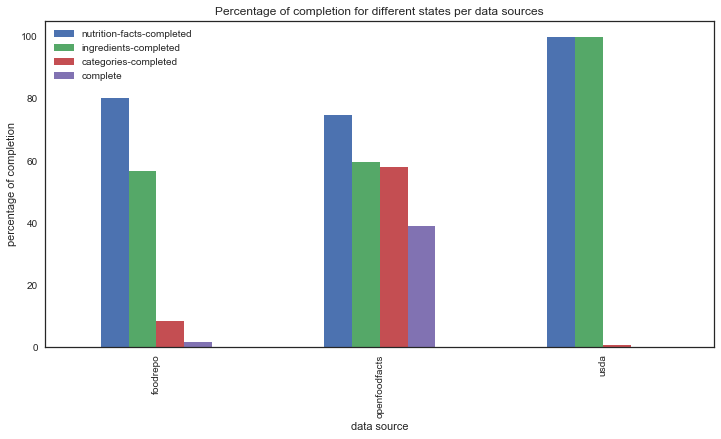

In [26]:
# Draw a plot for the facts, ingredients, categories and complete states per source
df_states_prop.loc[:, ['nutrition-facts-completed', 
                       'ingredients-completed', 
                       'categories-completed',
                       'complete'
                      ]].plot.bar(figsize=(12, 6))

plt.xlabel('data source')
plt.ylabel('percentage of completion')
plt.title('Percentage of completion for different states per data sources')
plt.show()

As we can see, the USDA NDB datasource provides only the product name, brand, ingredients and nutrition facts. It reflects well the collection process (in which manufacturers provide the data). Same idea for the Food Repo, volonteers take picture of products, so we have photo for each products but the extraction of other data are done afterwards.

In a next section, we will classify the food products by `pnns_group`, so at best, it will remain about 1'000 observations from the Food Repo and USDA datasources. 

Let's conclude this section by explaining the huge spike in the missing values analysis. Here, we display the distribution of missing values per observations, stacked by source.

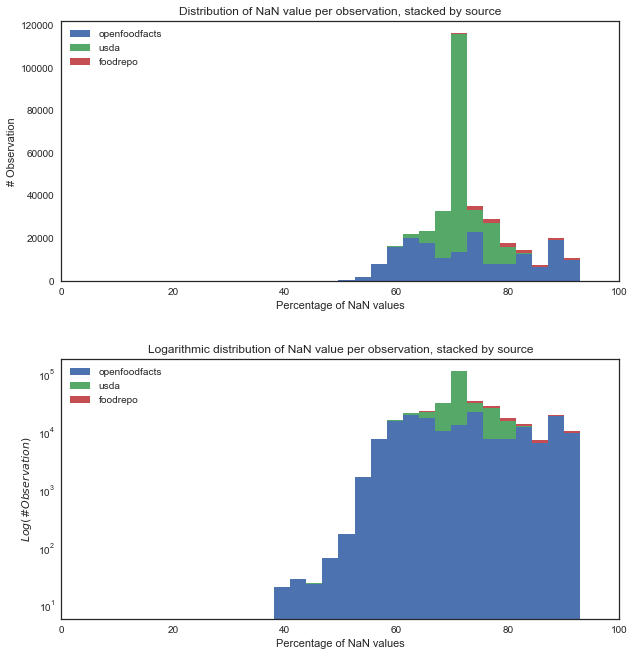

In [27]:
# Distribution of NaN value on rows stacked by source
dict = {}
for source in get_top_occurencies(data, 'source').index:
    df_source = data[data.source == source]
    dist = df_source.isnull().sum(axis=1) / df_source.shape[1] * 100
    dict[source] = dist


fig, ax = plt.subplots(nrows=2, ncols=1)
pd.DataFrame(dict).plot.hist(ax=ax[0], stacked=True, bins=20, figsize=(10, 11))
pd.DataFrame(dict).plot.hist(ax=ax[1], logy=True, stacked=True, bins=20, figsize=(10, 11))
plt.subplots_adjust(hspace=0.3)
ax[0].set_xlim(0, 100)
ax[1].set_xlim(0, 100)
ax[0].set_ymargin(1)
ax[0].set_xlabel('Percentage of NaN values')
ax[1].set_xlabel('Percentage of NaN values')
ax[0].set_ylabel('# Observation')
ax[1].set_ylabel('$Log(\# Observation)$')
ax[0].set_title('Distribution of NaN value per observation, stacked by source')
ax[1].set_title('Logarithmic distribution of NaN value per observation, stacked by source')
ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')
plt.show()

We clearly see that the spike is caused by the usda import data source and it confirm our intuition. The logarithmic plot give a better idea of the completion state of the data in the openfoodfacts project.

These previous parts was too much technical and near the database but we know our data and why they exists now. Let's dive in the temporal dimension and investigate about the task force behind the openfoodfacts project and if it is a healthy project or a dying opensource project.

### Number of products added each month and groth over the timeline

We will use the `created_datetime` variable to answer the following questions:

- When the integration of the usda and foodrepo has been done
- Look at the number of products added in the openfoodfacts database each month
- The growth of the number of product in the openfoodfacts database over the timeline of our dataset

In [28]:
# Look at when the integration of the usda database has been done
data.loc[data.source == 'usda'].groupby(data.created_datetime.dt.date).size()

created_datetime
2017-03-09    132035
2017-03-10     37627
dtype: int64

In [29]:
# Look at when the integration of the foodrepo database has been done
data.loc[data.source == 'foodrepo'].groupby(data.created_datetime.dt.date).size()

created_datetime
2017-02-07    11466
dtype: int64

We can see that the foodrepo and usda data sources have been included in the dataset in february and march 2017 respectively.  

Let's visualize the number of products added each month in the openfoodfacts database. We must first build a time-series with the number of products created each day :

In [30]:
# Number of products created each day
counts_per_day = data[data.source == 'openfoodfacts'].groupby(data.created_datetime.dt.date).size()

# Set the index as a datetime index
counts_per_day.index = pd.to_datetime(counts_per_day.index)

# Fill the hole in the data (missing days) with 0 products created
counts_per_day = counts_per_day.asfreq('D', fill_value=0)

In [31]:
# Resample the time-series to have the number of created items per month
counts_per_month = counts_per_day.resample('M').sum()
counts_per_month.head()

created_datetime
2012-01-31      1
2012-02-29     13
2012-03-31    170
2012-04-30    220
2012-05-31    458
Freq: M, dtype: int64

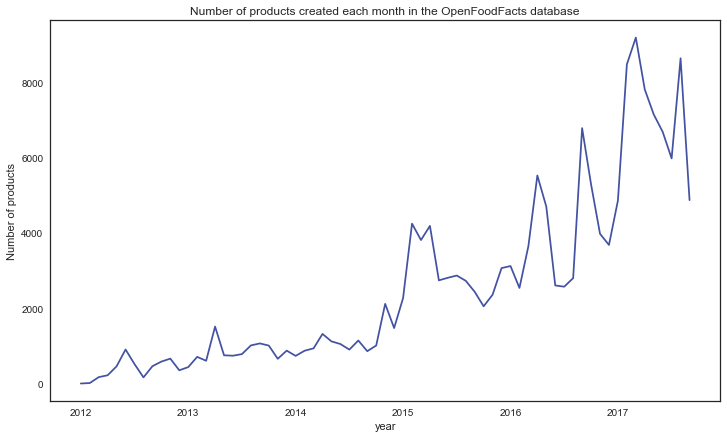

In [32]:
# Plot the number of products created each month
counts_per_month.plot(figsize=(12, 7), color='#4352a2')
plt.xlabel('year')
plt.ylabel('Number of products')
plt.title('Number of products created each month in the OpenFoodFacts database')
plt.show()

Over the years, the number of record added each month presents an exponential/quadratic growth. The Openfood fact project is in good health. A cumulative sum of the number of products over the timeline will give us a better vizualisation.

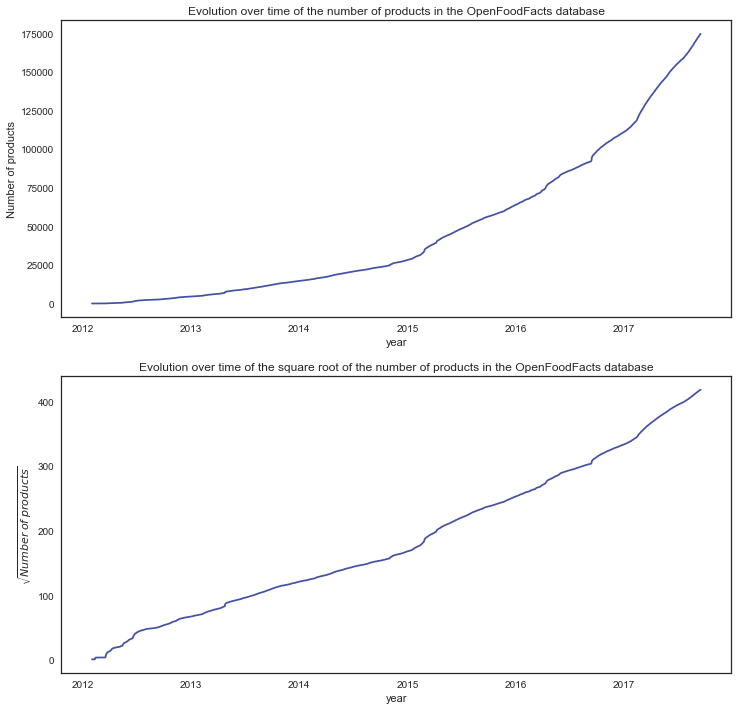

In [33]:
# Plot a cumulative sum of the number of products over time and also its square root 
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))
counts_per_day.cumsum().plot(ax=ax1, color='#4352a2')
np.sqrt(counts_per_day.cumsum()).plot(ax=ax2, color='#4352a2')
ax1.set_xlabel('year')
ax2.set_xlabel('year')
ax1.set_ylabel('Number of products')
ax2.set_ylabel('$\sqrt{Number\:of\:products}$')
ax1.set_title('Evolution over time of the number of products in the OpenFoodFacts database')
ax2.set_title('Evolution over time of the square root of the number of products in the OpenFoodFacts database')
plt.show()

We can see that the square root of the number of products in the database grows linearly over time.  
The number of products in the database follow a quadratric trend.

### Summary

It closes our first topic analysis. It was definitively more technical than scientific oriented but we just learned a lot of things about our data.

The openfoodfacts project is a healthy project that interest people and I hope they will improve the way data are collected, with technologies that could improve with automation the quality of the data.

## B.2 Allergens Analysis

In this analysis, we will focus on allergens and try to find the most common allergens.

Let's first extract a DataFrame with the required variables:

In [34]:
# Build a dataframe with the required variables
df = data.loc[data.allergens.notnull(), ['product_name', 'allergens', 'source']].copy()

print('Shape of the DataFrame: {}'.format(df.shape))
df.head()

Shape of the DataFrame: (37149, 3)


,product_name,allergens,source
code,,,
0000007730009,Biscuits sablés fourrage au cacao,"Blé, Beurre, Oeufs, Noisette",openfoodfacts
0000020004552,Côtes du Rhône Villages 2014,sulfites,openfoodfacts
0000020424640,Belgische Pralinen,"Vollmilchpulver, Vollmilchpulver, Soja, Butter...",openfoodfacts
0000027533024,Luxury Christmas Pudding,"Wheat Flour, Milk, Walnuts, Almonds, Nut, Whea...",openfoodfacts
0000027533048,Luxury Christmas Pudding,"Wheat Flour, Milk, Walnuts, Almonds, Nut, Whea...",openfoodfacts


In [35]:
# Show the allergens data to have an idea about the cleaning that should be done
df.allergens.head(100)

code
0000007730009                         Blé, Beurre, Oeufs, Noisette
0000020004552                                             sulfites
0000020424640    Vollmilchpulver, Vollmilchpulver, Soja, Butter...
0000027533024    Wheat Flour, Milk, Walnuts, Almonds, Nut, Whea...
0000027533048    Wheat Flour, Milk, Walnuts, Almonds, Nut, Whea...
0000084154071                                              mostaza
000010                                       blé, oeufs, blé, lait
0000204286484    Sojaprotein, Weizenprotein, Molkenprotein, Whe...
0000204286644    Sojaprotein, Weizenprotein, Molkenprotein, Whe...
0000250632969    Sojaprotein, Weizenprotein, Molkenprotein, Whe...
000030                                        blé, œufs, blé, lait
0000460938714                                                 Soja
0000470322800                                Wheyproteinkonzentrat
000050                        œufs, amande, beurre, blé, œufs, blé
0000501050603                                Wheyproteink

We can see that the data are messy. We have a lot of duplicates, synonyms for the same kind of allergens, multiple langages (french, english, but many others like russian), some of them are capitalized, etc.

In [36]:
# Gluten allergen in russian
get_top_occurencies_containing(df, 'allergens', 'глютен', 5)

,count,count %
allergens,,
глютен,4,0.01
"твердой пшеницы, глютен",1,0.00
"глютен, яйца",1,0.00
"глютен, белок молока",1,0.00


We will adress the preparation of the data in five steps:

1. Cleaning the data with text manipulation: everything in lowercases, stripping and removing the whitespaces
2. Extraction of the individual allergens to have a DataFrame with one allergen per observation (so multiple observations per products)
3. Build a dictionnary with translation and synonyms of the allergens by webscrapping a page on the OpenFoodFact Wiki
4. Translate our data and remove the duplicates after translation
5. Enjoy the result and find the most common allergens

### Cleaning the allergen source data

In [37]:
# Everything in lowercases
df['allergens_c'] = df.allergens.str.lower()

# Strip whitespaces
df.allergens_c = df.allergens_c.str.strip()

# Replace multiple whitespaces with only one space
df.allergens_c = df.allergens_c.str.replace(r"\s+", " ")

# Remove whitespaces after comma
df.allergens_c = df.allergens_c.str.replace(r",\s+", ",")

# Remove some special characters (used in regex)
df.allergens_c = df.allergens_c.str.replace(r"[\*|\?|\.]", "")

In [38]:
# Check the result after cleaning
df.allergens_c.tail(100)

code
9310663800017                    wheat,soy,soy,wheat,soy,milk,milk
9310761713370                        soy,milk,milk,soy,wheat,wheat
9311005000034                                                wheat
9311008437776                                     gluten,wheat,soy
9311165777777                                                 milk
9311361004257                                 nuts,fish,gluten,egg
9311482002958                                                 milk
9311710801759                                                 milk
9311832314007                                             sulfites
9312231222023                            organic whole oats,gluten
9312336049013                                         soybeans,soy
9314507358405                                       schwefeldioxid
9315054001585                                                 nuts
9315303006453    wheat,soy,wheat,gluten,soy,egg,egg,egg,mustard...
9315866405014            wheat,oats,almonds,hazelnuts,whe

### Allergens Extraction

We want a DataFrame with one allergen per observation :

In [39]:
# Extract the allergens (one observation per code per allergen, multi-index = code + match )
df_allergens = df.allergens_c.str.extractall(r"(?P<allergen>[^,]+)")

# Reset the index
df_allergens.reset_index(inplace=True)

# Drop the automatically created column: match
df_allergens.drop('match', axis=1, inplace=True)

# Remove duplicates
df_allergens.drop_duplicates(inplace=True)

df_allergens.head(10)

,code,allergen
0,0000007730009,blé
1,0000007730009,beurre
2,0000007730009,oeufs
3,0000007730009,noisette
4,0000020004552,sulfites
5,0000020424640,vollmilchpulver
7,0000020424640,soja
8,0000020424640,butterreinfett
9,0000020424640,haselnusskerne
11,0000020424640,mandeln


We are missing the product name and source, let's merge the two dataframes :

In [40]:
# Set the code as the index
df_allergens.set_index('code', inplace=True)

# Merge the dataframes to have one allergen per observation but with also the description of the product
df_allergens = df_allergens.merge(df.loc[:, ['product_name', 'source']], on='code')
df_allergens.head()

,allergen,product_name,source
code,,,
0000007730009,blé,Biscuits sablés fourrage au cacao,openfoodfacts
0000007730009,beurre,Biscuits sablés fourrage au cacao,openfoodfacts
0000007730009,oeufs,Biscuits sablés fourrage au cacao,openfoodfacts
0000007730009,noisette,Biscuits sablés fourrage au cacao,openfoodfacts
0000020004552,sulfites,Côtes du Rhône Villages 2014,openfoodfacts


### Build a Dictionnary of Allergens Taxonomies (web scrapping)

Our data are now ready to be translated, we need now to build a dictionnary to translate the allergens and replace the different synonyms by their corresponding taxonomies. The OpenFoodFact Wiki provides the taxonomies at this url: [Allergen Taxonomies](https://en.wiki.openfoodfacts.org/Global_allergens_taxonomy).

On this webpage, we can see the different taxonomies: en:gluten, en:crustaceans, en:eggs, etc. with different synonyms in a lot of different langages. Perfect !

We will use the BeautifulSoup library to web scrape the webpage : 

In [41]:
# Import the required libraries for web scrapping
import requests
from bs4 import BeautifulSoup

In [42]:
# GET the webpage containing the allergen taxonomies
url = 'https://en.wiki.openfoodfacts.org/Global_allergens_taxonomy'
response = requests.get(url)

print('Response status code: {}'.format(response.status_code))
print('Response text:\n {}'.format(response.text))

Response status code: 200
Response text:
 <!DOCTYPE html>
<html class="client-nojs" lang="en" dir="ltr">
<head>
<meta charset="UTF-8"/>
<title>Global allergens taxonomy - Open Food Facts EN</title>
<script>document.documentElement.className = document.documentElement.className.replace( /(^|\s)client-nojs(\s|$)/, "$1client-js$2" );</script>
<script>(window.RLQ=window.RLQ||[]).push(function(){mw.config.set({"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":false,"wgNamespaceNumber":0,"wgPageName":"Global_allergens_taxonomy","wgTitle":"Global allergens taxonomy","wgCurRevisionId":8092,"wgRevisionId":8092,"wgArticleId":198,"wgIsArticle":true,"wgIsRedirect":false,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Global Taxonomies","Translations"],"wgBreakFrames":false,"wgPageContentLanguage":"en","wgPageContentModel":"wikitext","wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February",

Taxonomies are enclosed in a *pre* tag. Let's parse the html code to extract them :

In [43]:
# parse the html code as a BeautifulSoup object
html = BeautifulSoup(response.text, 'html.parser')

# All allergens, synonyms and translations are inside a <pre> tag
text = html.find_all('pre')[0].text
print(text)


en:gluten, wheat, rye, barley, oats, spelt, kamut, wheat semolina, wheat flour
ar:غلوتين
bg:глутен, ечемик, ечемичен, ечемично-малцов, пшеница, пшенично, ръж,  овес, шпелта, камут, вид едра твърда пшеница
cs:lepek, pšenice, žito, ječmen, oves, špalda, kamut
da:gluten, hvede, rug, byg, havre, spelt, kamut
de:Gluten, Weizen, Roggen, Gerste, Hafer, Dinkel, Kamut, Gerstenmehl, Gerstenvollkornmehl, Hafer-Vollkornmehl, Haferflocken, Haferkleie, Hafervollkornflocken, Hafervollkornmehl, Vollkorn-Hafer, Vollkorn-Haferflocken, Vollkorn-Hafermehl, Vollkornhafermehl, Vollkornhafer, Vollkornhaferflocken, Vollkornhaferschrot, Vollkornweizenmehl, Weizenvollkornmehl, Weizenmehl, Weizengluten, Weizensauerteig, Hartweizen
ee:nisu, odrasiirup, odralinnaseekstrakt
el:γλουτένη, σιτάρι, σίκαλη, κριθάρι, βρώμη, ντίνκελ, σιτηρό kamut
es:gluten, trigo, centeno, cebada, avena, espelta, kamut, cereales con gluten, cereales, harina de trigo, trigo de Jorasán Kamut, harina de trigo integral
et:gluteen, nisu, nisu

The different allergen taxonomies are separated by empty lines.  
We can build a list by splitting the text with this separator, and build a DataFrame from the list :

In [44]:
# Allergens with their synonyms and translations are split by an empty line, so let's extract them in a dataframe
taxonomy_list = text.split('\n\n')

# Built a dataframe
taxonomies = pd.DataFrame({'text': taxonomy_list})
taxonomies

,text
0,"\nen:gluten, wheat, rye, barley, oats, spelt, ..."
1,<en:gluten\nde:Gluten enthaltendes Getreide\ne...
2,"en:crustaceans, crab, lobster, crayfish, prawn..."
3,"en:eggs, egg\nar:بيض,بيضة\nbg:яйца, яйце\ncs:v..."
4,"en:fish, fishes, cod, mackerel, flounder, hali..."
5,"en:peanuts, peanut, arachis hypogaea\nar:فول س..."
6,"en:soybeans, soya, soja, soia, soy\nar:فول الص..."
7,"en:milk, lactose, whey, dairy, butter, cream, ..."
8,"en:nuts, almonds, hazelnuts, walnuts, cashews,..."
9,"en:celery, celeraic\nar:كرفس\nbg:целина\ncs:ce..."


The 12 & 16 observations are not taxonomies, we can drop them and we must do some cleaning also :

In [45]:
# drop the 12 & 16 index 
taxonomies.drop([12, 16], inplace=True)

# strip the withspaces
taxonomies.text = taxonomies.text.str.strip()

# remove the < symbol at the beginning (observation 1)
taxonomies.text = taxonomies.text.str.replace(r'^<','')

# remove the whitespaces after the comma
taxonomies.text = taxonomies.text.str.replace(r',\s+', ',')

# everything in lowercase
taxonomies.text = taxonomies.text.str.lower()

# remove the wikidata annotation at the end of each taxonomy
taxonomies.text = taxonomies.text.str.replace(r'\nwikidata.*$', '')

taxonomies.text

0     en:gluten,wheat,rye,barley,oats,spelt,kamut,wh...
1     en:gluten\nde:gluten enthaltendes getreide\nen...
2     en:crustaceans,crab,lobster,crayfish,prawn,shr...
3     en:eggs,egg\nar:بيض,بيضة\nbg:яйца,яйце\ncs:vej...
4     en:fish,fishes,cod,mackerel,flounder,halibut,t...
5     en:peanuts,peanut,arachis hypogaea\nar:فول سود...
6     en:soybeans,soya,soja,soia,soy\nar:فول الصويا\...
7     en:milk,lactose,whey,dairy,butter,cream,yogurt...
8     en:nuts,almonds,hazelnuts,walnuts,cashews,cash...
9     en:celery,celeraic\nar:كرفس\nbg:целина\ncs:cel...
10    en:mustard,brassica\nar:خردل\nbg:синап\ncs:hoř...
11    en:sesame seeds,sesame\nar:سمسم\nbg:сусамово с...
13    en:sulphur dioxide and sulphites,sulphur dioxi...
14    en:lupin\nar:ترمس\nbg:лупина\ncs:vlčí bob,lupi...
15    en:molluscs,mollusc,mollusks,mollusk,squid,cut...
Name: text, dtype: object

The taxonomy is the first en:... on each observation. Let's extract them and replace the index with them :

In [46]:
# Extract the allergens main taxonomy (the first en: until the comma or \n)
taxonomies['allergen'] = taxonomies.text.str.extract(r'en:([^\n,]+)')

# Set the allergen as the dataframe index
taxonomies.set_index('allergen', inplace=True)

taxonomies.head()

,text
allergen,
gluten,"en:gluten,wheat,rye,barley,oats,spelt,kamut,wh..."
gluten,en:gluten\nde:gluten enthaltendes getreide\nen...
crustaceans,"en:crustaceans,crab,lobster,crayfish,prawn,shr..."
eggs,"en:eggs,egg\nar:بيض,بيضة\nbg:яйца,яйце\ncs:vej..."
fish,"en:fish,fishes,cod,mackerel,flounder,halibut,t..."


We need now to extract each langages to have on row per allergen and langage. Langages are separated by line return :

In [47]:
# Extract all langages (to have one row per allergen and langages)
allergens_translations = taxonomies.text.str.extractall(r'(?P<translations>[^\n]+)')

# Reset index
allergens_translations.reset_index(inplace=True)

# Drop the automatically created match column
allergens_translations.drop(['match'], axis=1, inplace=True)

allergens_translations.head(10)

,allergen,translations
0,gluten,"en:gluten,wheat,rye,barley,oats,spelt,kamut,wh..."
1,gluten,ar:غلوتين
2,gluten,"bg:глутен,ечемик,ечемичен,ечемично-малцов,пшен..."
3,gluten,"cs:lepek,pšenice,žito,ječmen,oves,špalda,kamut"
4,gluten,"da:gluten,hvede,rug,byg,havre,spelt,kamut"
5,gluten,"de:gluten,weizen,roggen,gerste,hafer,dinkel,ka..."
6,gluten,"ee:nisu,odrasiirup,odralinnaseekstrakt"
7,gluten,"el:γλουτένη,σιτάρι,σίκαλη,κριθάρι,βρώμη,ντίνκε..."
8,gluten,"es:gluten,trigo,centeno,cebada,avena,espelta,k..."
9,gluten,"et:gluteen,nisu,nisugluteen,rukis,oder,odra,ka..."


### Allergens translation

We have now everything to replace the allergen source data by their corresponding taxonomies :

In [48]:
# Function that returns the allergen taxonomy if found or the allergen (input) else
def get_allergen_translation(x):
    result = allergens_translations[allergens_translations.translations.str.contains(x)]
    if result.shape[0] > 0:
        return result.allergen.iloc[0]
    else:
        return x

# Function that returns if an allergen taxonomy has been found    
def has_translation(x):
    result = allergens_translations[allergens_translations.translations.str.contains(x)]
    return result.shape[0] > 0

# Add a variable with the allergen translation/taxonomy
df_allergens['allergen_translation'] = df_allergens.allergen.map(get_allergen_translation)

# Add a variable that indicates if a translation/taxonomy has been found
df_allergens['translated'] = df_allergens.allergen.map(has_translation)

Because we could have multiple synonyms for the same allergen taxonomy, we have probably new duplicates after translation. We need to drop them :

In [49]:
# Reset the index
df_allergens.reset_index(inplace=True)

# Drop the duplicates (created by translation because some product has multiple synonyms for the same allergen)
df_allergens.drop_duplicates(subset=['code', 'allergen_translation'], inplace=True)

# Capitalize the allergen translation
df_allergens.allergen_translation = df_allergens.allergen_translation.str.capitalize()

df_allergens.loc[:, ['code', 'product_name', 'allergen', 'allergen_translation']].head(10)

,code,product_name,allergen,allergen_translation
0,0000007730009,Biscuits sablés fourrage au cacao,blé,Gluten
1,0000007730009,Biscuits sablés fourrage au cacao,beurre,Milk
2,0000007730009,Biscuits sablés fourrage au cacao,oeufs,Eggs
3,0000007730009,Biscuits sablés fourrage au cacao,noisette,Nuts
4,0000020004552,Côtes du Rhône Villages 2014,sulfites,Sulphur dioxide and sulphites
5,0000020424640,Belgische Pralinen,vollmilchpulver,Milk
6,0000020424640,Belgische Pralinen,soja,Soybeans
8,0000020424640,Belgische Pralinen,haselnusskerne,Nuts
10,0000020424640,Belgische Pralinen,pisatazien,Pisatazien
12,0000027533024,Luxury Christmas Pudding,wheat flour,Gluten


Cool, right ? From very messy data we have now interesting data ready for analysis.

In [50]:
# Compute the translation ratio
translation_percent = np.round(df_allergens.translated.sum() / df_allergens.shape[0] * 100, 2)

print('Allergen taxonomies translation percentage : {}%'.format(translation_percent))

Allergen taxonomies translation percentage : 91.74%


Not bad for a simple *contains* algorithm. We could improve this percentage by treating the plural form of some words. For example, *fromages* has not been translated to *milk* because it is in plural... We will not do it now because it isn't our goal but if we would like to build an app around allergens it could be a good time investment.

### Analysis: The Most Common Allergens

In [51]:
allergens_occurences = get_top_occurencies(df_allergens[df_allergens.translated], 'allergen_translation', 20)
allergens_occurences

,count,count %
allergen_translation,,
Milk,20310,29.68
Gluten,17414,25.45
Eggs,7922,11.58
Soybeans,7466,10.91
Nuts,3844,5.62
Mustard,2434,3.56
Fish,2366,3.46
Sulphur dioxide and sulphites,1971,2.88
Celery,1861,2.72


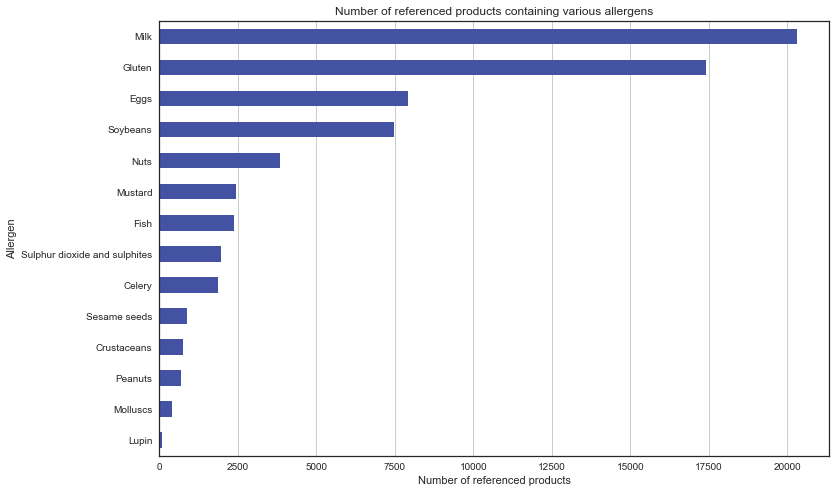

In [52]:
# Draw a bar plot of the most common allergens
ax = allergens_occurences['count'].plot.barh(figsize=(12, 8), color='#4352a2')
ax.invert_yaxis()
ax.xaxis.grid()

plt.title('Number of referenced products containing various allergens')
plt.xlabel('Number of referenced products')
plt.ylabel('Allergen')
plt.show()

Life must be difficult when we have an intolerance to milk and gluten...

### Summary

It closes our second analysis topic. We find that Milk and Gluten are by far the most common allergens. Eggs and Soybeans are also common. By digging in the data, we can find that swandwich, one-dish meals and prepared foods in general contain the most allergens. Sushi box can contain more than 8 different allergens for exemple. 

For further exploration, the following DataFrame allows to easely filter products by allergens (transformed as indicator variables) and provides also the number of allergens by product.

In [53]:
# Pivot the table to have one variable for each allergen taxonomy 
# with True/False indicating if the product contains the corresponding allergen
df_allergens_pivot = df_allergens[df_allergens.translated].pivot_table(index='code', 
                                                                       columns='allergen_translation', 
                                                                       values='translated',
                                                                       fill_value=False)

# Count the number of allergen per products
df_allergens_pivot['allergen_count'] = df_allergens_pivot.sum(axis=1)

# Recover the product_name variable by joining the df_alergens dataframe
df_allergens_pivot = pd.concat([df_allergens_pivot, data.product_name], axis=1, join='inner')

# Reindex the columns (nicer in this order)
cols = ['product_name', 'allergen_count'] + df_allergens_pivot.columns[0:13].values.tolist()
df_allergens_pivot = df_allergens_pivot.reindex(columns=cols)

# Example: Products with at least 8 allergens and that contains sesame seed
df_allergens_pivot[(df_allergens_pivot.allergen_count >= 8) & df_allergens_pivot['Sesame seeds']]

,product_name,allergen_count,Celery,Crustaceans,Eggs,Fish,Gluten,Lupin,Milk,Molluscs,Mustard,Nuts,Peanuts,Sesame seeds,Soybeans
code,,,,,,,,,,,,,,,
2000000024231,280 sauce Moutarde de Dijon,8.0,False,False,True,False,True,False,True,False,True,True,False,True,True
20400309,Pain Multicereals,8.0,False,False,True,False,True,True,True,False,True,True,False,True,True
3038680020046,Coffret plaisir 16 pièces,8.0,False,True,True,True,True,False,True,False,True,False,False,True,True
3250391292615,Bouchées vapeur,8.0,False,True,True,True,True,False,True,False,False,False,False,True,True
3660088136984,Nos toasts chauds,9.0,True,True,True,True,True,False,False,True,True,False,False,True,False
3700212554694,Terrine d'avocat au crabe,8.0,False,True,True,True,True,False,True,True,False,False,False,True,True
4045851002014,"Edogawa, Sushi Box Matsu, (4 nigri saumo- 4 ni...",8.0,False,True,True,True,True,False,True,False,True,False,False,True,True
4045851007019,11 Sushi Box Taito,8.0,False,True,True,True,True,False,True,False,True,False,False,True,True


It could be an opportunity to build a very simple and visual mobile app "Allergen Radar" !

## B.3 Food Macronutrients Composition and Energy

In this analysis, we will investigate the macronutrients breakdown across various kind of food. We will use the `pnns_groups` classification variables to summarize our results. We will look at if there are correlation between energy and the macronutrients breakdown (carbohydrates, fats and proteins).

Let's start by building a DataFrame with the products with pnns groups and do some cleaning :

In [54]:
# Build a DataFrame with only the product having pnns groups and energy greater than 0
df_nutrients = data.loc[(data.pnns_groups_1.notnull()) & (data.pnns_groups_2.notnull()) & (data.energy_100g > 0), :].copy()

print('DataFrame shape: {}'.format(df_nutrients.shape))

DataFrame shape: (104319, 142)


### PNNS Groups Cleaning

In [55]:
# Get the PNNS Groups 1 existing values
pd.DataFrame({'PNNS Group 1': df_nutrients.pnns_groups_1.unique()})

,PNNS Group 1
0,unknown
1,Fruits and vegetables
2,Sugary snacks
3,Beverages
4,Composite foods
5,Fish Meat Eggs
6,Fat and sauces
7,Salty snacks
8,Cereals and potatoes
9,Milk and dairy products


In [56]:
# Get the PNNS Groups 2 existing values
pd.DataFrame({'PNNS Group 2': df_nutrients.pnns_groups_2.unique()})

,PNNS Group 2
0,unknown
1,Vegetables
2,Biscuits and cakes
3,Sweetened beverages
4,Pizza pies and quiche
5,Meat
6,Sweets
7,Non-sugared beverages
8,Dressings and sauces
9,One-dish meals


As we can see, for both groups, the cleaning is not difficult. We have some duplicates that can be removed by replacing the *-* by whitespaces and by capitalizing everything :

In [57]:
# Strip
df_nutrients.pnns_groups_1 = df_nutrients.pnns_groups_1.str.strip()
df_nutrients.pnns_groups_2 = df_nutrients.pnns_groups_2.str.strip()

# Capitalize every groups
df_nutrients.pnns_groups_1 = df_nutrients.pnns_groups_1.str.capitalize()
df_nutrients.pnns_groups_2 = df_nutrients.pnns_groups_2.str.capitalize()

# Replace the - by whitespaces
df_nutrients.pnns_groups_1 = df_nutrients.pnns_groups_1.str.replace('-', ' ')
df_nutrients.pnns_groups_2 = df_nutrients.pnns_groups_2.str.replace('-', ' ')

In [58]:
# Check the cleaning
pd.DataFrame({'PNNS Group 1': df_nutrients.pnns_groups_1.unique()})

,PNNS Group 1
0,Unknown
1,Fruits and vegetables
2,Sugary snacks
3,Beverages
4,Composite foods
5,Fish meat eggs
6,Fat and sauces
7,Salty snacks
8,Cereals and potatoes
9,Milk and dairy products


### Variable and Observations Selection

Here, we keep only observations and variables we will use during the analysis. In the data, there are products classified with *Unknown* PNNS Groups, we will drop them because not really informative. Concerning the facts, our analysis will concern only the top level facts present on each products (carbohydrates, fats, proteins, fibers and salt).

But for cleaning purpose only, we will also take their first sublevel breakdown and check if the data are coherent beetween top level and their breakdown (exemple: carbohydrates must be greater than the sum of sugar, starch and polyols). To clean these potential incoherences, we must replace missing values by 0.

In [59]:
# Variables we want to keep
# (top level macronutrients (indicated on each product) and their first breakdown level)
col_list = ['product_name',
            'pnns_groups_1',
            'pnns_groups_2',
            'source',
            'energy_100g',
            'carbohydrates_100g',
            'sugars_100g',
            'starch_100g',
            'polyols_100g',
            'fat_100g',
            'saturated-fat_100g',
            'monounsaturated-fat_100g',
            'polyunsaturated-fat_100g',
            'trans-fat_100g',
            'proteins_100g',
            'casein_100g',
            'serum-proteins_100g',
            'fiber_100g',
            'salt_100g'
            ]

# Variables that will be used for the analysis (only top level macronutrients and energy)
facts_for_analysis = ['energy_100g',
                      'carbohydrates_100g',
                      'fat_100g',
                      'proteins_100g',
                      'fiber_100g',
                      'salt_100g'
                     ]

# Keep only the required variables and exclude the unknown pnns groups
df_nutrients = df_nutrients[df_nutrients.pnns_groups_1 != 'Unknown'].reindex(columns=col_list)

# Remove observations with missing values in macronutrients and energy
df_nutrients.dropna(subset=facts_for_analysis, inplace=True)

# Replace NaN values by 0
df_nutrients.fillna(value=0, inplace=True)

print('Number of observations: {}'.format(df_nutrients.shape[0]))
df_nutrients.head()

Number of observations: 38971


,product_name,pnns_groups_1,pnns_groups_2,source,energy_100g,carbohydrates_100g,sugars_100g,starch_100g,polyols_100g,fat_100g,saturated-fat_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,trans-fat_100g,proteins_100g,casein_100g,serum-proteins_100g,fiber_100g,salt_100g
code,,,,,,,,,,,,,,,,,,,
0000000290616,Salade Cesar,Fruits and vegetables,Vegetables,openfoodfacts,1210.0,23.00,0.000,0.0,0.0,12.00,7.00,0.00,0.00,0.000,22.00,0.0,0.0,2.000,2.1600
0000000394710,Danoises à la cannelle roulées,Sugary snacks,Biscuits and cakes,openfoodfacts,1520.0,54.10,28.100,0.0,0.0,14.40,0.00,0.00,0.00,0.000,4.79,0.0,0.0,2.050,0.9220
0000001938067,Chaussons tressés aux pommes,Sugary snacks,Biscuits and cakes,openfoodfacts,1090.0,38.70,24.700,0.0,0.0,10.70,2.00,3.33,5.33,0.667,3.33,0.0,0.0,2.000,0.6470
0000007020254,Root Beer,Beverages,Sweetened beverages,openfoodfacts,215.0,14.20,13.600,0.0,0.0,0.00,0.00,0.00,0.00,0.000,0.00,0.0,0.0,0.000,0.0616
0000008237798,Quiche Lorraine,Composite foods,Pizza pies and quiche,openfoodfacts,478.0,7.86,0.714,0.0,0.0,6.79,2.86,0.00,0.00,0.000,5.36,0.0,0.0,0.357,0.4990


### Removing products with incoherent breakdown values

Remember that we have already dropped products with negative facts and facts greater than 100g.
Here, we will just remove products that have incoherent facts values between the top level and their breakdown level (typing error).

In [60]:
# Utility function to drop incohenrent observations
# WARNING: this function works because variables are well ordered
def drop_observations_with_incoherent_breakdown(df, col_total, col_breakdown_start, col_breakdown_end, epsilon):
    breakdown_total  = df.loc[:, col_breakdown_start:col_breakdown_end].sum(axis=1)
    condition_filter = breakdown_total > (df[col_total] * (1 + epsilon))
    df.drop(df[condition_filter].index, inplace=True)

epsilon = 0.1  # tolerence for rounding error and protocol error measure 

# Carbohydrates: remove observations with sum of carbohydrates breakdown greater than the carbohydrates total (with tolerence)
drop_observations_with_incoherent_breakdown(df_nutrients, 
                                            col_total = 'carbohydrates_100g', 
                                            col_breakdown_start = 'sugars_100g', 
                                            col_breakdown_end = 'polyols_100g', 
                                            epsilon = epsilon)

# Fats: remove observations with sum of fats breakdown greater than the fats total (with tolerence)
drop_observations_with_incoherent_breakdown(df_nutrients, 
                                            col_total = 'fat_100g', 
                                            col_breakdown_start = 'saturated-fat_100g', 
                                            col_breakdown_end = 'trans-fat_100g', 
                                            epsilon = epsilon)

# Proteins: remove observations with sum of proteins breakdown greater than the proteins total (with tolerence)
drop_observations_with_incoherent_breakdown(df_nutrients, 
                                            col_total = 'proteins_100g', 
                                            col_breakdown_start = 'casein_100g', 
                                            col_breakdown_end = 'serum-proteins_100g', 
                                            epsilon = epsilon)

print('Number of observations: {}'.format(df_nutrients.shape[0]))

Number of observations: 38840


### Removing outliers per PNNS Groups

In this section, we will remove outliers products in each PNNS Groups. A product in a PNNS Group is considered as an outlier if any of the following values are farther than 3 sigma from the mean of its PNNS Group :

- energy_100g
- carbohydrates_100g
- fats_100g
- proteins_100g
- fiber_100g
- salt_100g

In [61]:
# Function to drop outliers in regards of the top-level facts variables (defined in facts_for_analysis)
def drop_outliers(group, nsigma=3):
    g = group.loc[:, facts_for_analysis]
    is_outlier = np.abs(g - g.mean()) > (nsigma * g.std())
    outliers = g[is_outlier.any(axis=1)]
    return group.drop(outliers.index, axis=0)

# Group products by pnns groups
by_pnns = df_nutrients.groupby(['pnns_groups_1', 'pnns_groups_2'])

# Drop outliers
df_nutrients = by_pnns.apply(drop_outliers)

# Reset the index (because after the groupby, it is a multi index: pnns_groups_1 | pnns_groups_2 | row index)
df_nutrients.reset_index(level=[0, 1], drop=True, inplace=True)

print('Number of observations: {}'.format(df_nutrients.shape[0]))

Number of observations: 36488


With the outliers removed, let's check the number of products per PNNS Groups :

In [62]:
# Get the number of product by pnns groups 
by_pnns = df_nutrients.groupby(['pnns_groups_1', 'pnns_groups_2'])
by_pnns.size().sort_values(ascending=False)

pnns_groups_1            pnns_groups_2                   
Composite foods          One dish meals                      3601
Sugary snacks            Biscuits and cakes                  3005
Cereals and potatoes     Cereals                             2814
Beverages                Non sugared beverages               2167
Sugary snacks            Sweets                              1899
Fruits and vegetables    Vegetables                          1873
Fat and sauces           Dressings and sauces                1647
Milk and dairy products  Milk and yogurt                     1614
Sugary snacks            Chocolate products                  1610
Cereals and potatoes     Bread                               1522
Salty snacks             Appetizers                          1432
Cereals and potatoes     Breakfast cereals                   1430
Beverages                Sweetened beverages                 1239
                         Fruit juices                        1046
Fruits and vegetab

We have only 15 products in the *Salty and fatty products* (essentially PopCorn). It doesn't make sense to keep this PNNS Group. The one dish meals group contains 3601 products; if we would like to do our analysis with only a sample of the data, 60 observations per group (square root of 3600) would be a minimum. We can keep the Potatoes group with its only 68 observations. 

In [63]:
# Keep observations from PNNS Groups that contain at least 60 products (square root of 3600 -> the biggest pnns group)
size_min = 60
df_nutrients = by_pnns.filter(lambda x: x.shape[0] >= size_min)

print('Number of observations: {}'.format(df_nutrients.shape[0]))

Number of observations: 36473


### Statistics : Macronutrients by PNNS Groups

Our data are now cleaned and we can go ahead with the analysis and compute some statistics by pnns groups :

In [64]:
# Compute the statistics by pnns groups
by_pnns = df_nutrients.groupby(['pnns_groups_1', 'pnns_groups_2'])
stats_by_pnns = by_pnns.describe()

# Buid a DataFrame with only the mean (just for readability)
means_by_pnns = stats_by_pnns.loc[:, (facts_for_analysis , 'mean')]

# Remove the column index level 1
means_by_pnns.columns = means_by_pnns.columns.droplevel(1)

# Change the order of the variables (energy first then macronutrients)
means_by_pnns = means_by_pnns.reindex(columns=facts_for_analysis)
means_by_pnns.round(2)

energy_100g  \
pnns_groups_1           pnns_groups_2                                   
Beverages               Artificially sweetened beverages        56.38   
                        Fruit juices                           196.04   
                        Fruit nectars                          189.94   
                        Non sugared beverages                  160.84   
                        Sweetened beverages                    306.81   
Cereals and potatoes    Bread                                 1306.31   
                        Breakfast cereals                     1693.88   
                        Cereals                               1336.04   
                        Legumes                                956.86   
                        Potatoes                               472.81   
Composite foods         One dish meals                         547.01   
                        Pizza pies and quiche                  972.03   
                        Sandwich                               992.28   
Fat and sauces          Dressings and sauces                   781.17   
                        Fats                                  3118.75   
Fish meat eggs          Eggs                                   596.48   
                        Fish and seafood                       702.74   
                        Meat                                   690.68   
                        Processed meat                         964.30   
Fruits and vegetables   Dried fruits                          1422.06   
                        Fruits                                 295.03   
                        Soups                                  165.88   
                        Vegetables                             186.89   
Milk and dairy products Cheese                                1159.19   
                        Dairy desserts                         630.88   
                        Ice cream                              906.52   
                        Milk and yogurt                        346.01   
Salty snacks            Appetizers                            2068.85   
                        Nuts                                  2584.63   
Sugary snacks           Biscuits and cakes                    1910.00   
                        Chocolate products                    2165.18   
                        Pastries                              1531.50   
                        Sweets                                1423.53   

                                                          carbohydrates_100g  \
pnns_groups_1           pnns_groups_2                                          
Beverages               Artificially sweetened beverages                2.91   
                        Fruit juices                                   10.64   
                        Fruit nectars                                  10.75   
                        Non sugared beverages                           7.52   
                        Sweetened beverages                            16.73   
Cereals and potatoes    Bread                                          55.21   
                        Breakfast cereals                              68.74   
                        Cereals                                        60.15   
                        Legumes                                        19.43   
                        Potatoes                                       17.01   
Composite foods         One dish meals                                 12.06   
                        Pizza pies and quiche                          25.30   
                        Sandwich                                       24.21   
Fat and sauces          Dressings and sauces                           11.94   
                        Fats                                            0.85   
Fish meat eggs          Eggs                                            0.73   
                        Fish and seafood                      

It can be tempting to compare mean values and get some easy and fast conclusions but it's never a good idea to compare means without no knowledge about their standard deviation. The above dataframe displays only the means for readability convinence and as an invitation for our curiosity to ask questions we need to address more seriously.

1. Which foods contain the most fibers, with rank order ?

In [65]:
# First the innocent answer by just comparing the mean
fiber_rich_groups = means_by_pnns.fiber_100g.sort_values(ascending=False).head(4)
fiber_rich_groups

pnns_groups_1          pnns_groups_2    
Cereals and potatoes   Legumes              7.552006
Salty snacks           Nuts                 7.296988
Cereals and potatoes   Breakfast cereals    6.888448
Fruits and vegetables  Dried fruits         6.824051
Name: fiber_100g, dtype: float64

A better approach would be to compare the group statistics by drawing boxplots :

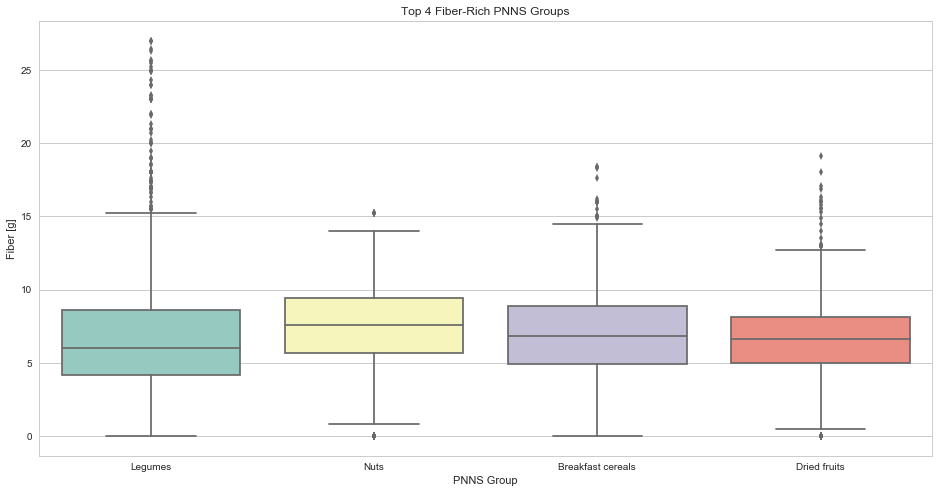

In [66]:
# Build a DataFrame with only product from the above pnns groups
pnns_groups_rich_fiber = fiber_rich_groups.index.get_level_values('pnns_groups_2')
df_nutrients_fiber = df_nutrients.loc[df_nutrients.pnns_groups_2.isin(pnns_groups_rich_fiber)]

# Draw a boxplox to compare the statistics of each group
sns.set(style="whitegrid")

plt.figure(figsize=(16, 8))
sns.boxplot(x='pnns_groups_2', 
            y='fiber_100g', 
            data=df_nutrients_fiber, 
            order=pnns_groups_rich_fiber, 
            palette='Set3')

plt.xlabel('PNNS Group')
plt.ylabel('Fiber [g]')
plt.title('Top 4 Fiber-Rich PNNS Groups')
plt.show()

First, we can see that the ranking would be different by comparing the medians; Nuts would be the food that contain the most fibers. But the good question to ask is if the mean/median differences are significant ? Can we really say that nuts contains more fibers than legumes, or more than dried fruits ?

Independent t-test can help us to answer these questions. As a null hyptothesis, we state that the means are the same and the difference we are observing is due by chance. The t-test tells us if we can or not reject the null hypothesis:

In [67]:
# Import the independent t-test method
from scipy.stats import ttest_ind

# Function to compute independent t-test with nice printed results
def compute_ttest_ind(df, group_1, group_2, variable):
    stat, pvalue = ttest_ind(df.loc[df.pnns_groups_2 == group_1, variable], 
                             df.loc[df.pnns_groups_2 == group_2, variable],
                             equal_var=False)
    print('{} VS {}\nstatistic: {}\np-value  : {}\nCan reject the null hypothesis: {}\n'.format(group_1, group_2, stat, pvalue, pvalue < 0.05))


compute_ttest_ind(df_nutrients_fiber, 'Nuts', 'Legumes', 'fiber_100g')
compute_ttest_ind(df_nutrients_fiber, 'Nuts', 'Dried fruits', 'fiber_100g')
compute_ttest_ind(df_nutrients_fiber, 'Nuts', 'Breakfast cereals', 'fiber_100g')
compute_ttest_ind(df_nutrients_fiber, 'Dried fruits', 'Breakfast cereals', 'fiber_100g')

Nuts VS Legumes
statistic: -0.912732703231179
p-value  : 0.36160568623937495
Can reject the null hypothesis: False

Nuts VS Dried fruits
statistic: 2.000212619443665
p-value  : 0.045855926246566266
Can reject the null hypothesis: True

Nuts VS Breakfast cereals
statistic: 2.3988406270670195
p-value  : 0.016737908749187548
Can reject the null hypothesis: True

Dried fruits VS Breakfast cereals
statistic: -0.3269523560185883
p-value  : 0.743844385382654
Can reject the null hypothesis: False



We fail to reject the null hypothesis when comparing Nuts and Legumes. We just can't say that Nuts contains more fibers than Legumes, so it would make no sense to give a ranking.

Let's compare the fiber composition for the Fruits and Vegetables group:

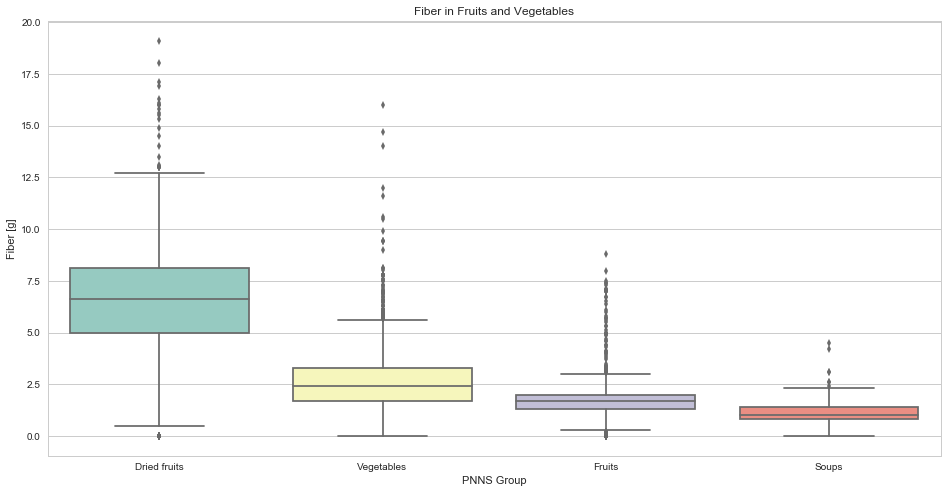

In [68]:
# Build a DataFrame with only product from the "Fruits and vegetables" pnns group 1 
df_nutrients_fiber = df_nutrients.loc[df_nutrients.pnns_groups_1 == 'Fruits and vegetables']

# Draw a boxplox to compare the statistics of each group
sns.set(style="whitegrid")

plt.figure(figsize=(16, 8))
sns.boxplot(x='pnns_groups_2', 
            y='fiber_100g', 
            data=df_nutrients_fiber, 
            order=['Dried fruits', 'Vegetables', 'Fruits', 'Soups'], 
            palette='Set3')

plt.xlabel('PNNS Group')
plt.ylabel('Fiber [g]')
plt.title('Fiber in Fruits and Vegetables')
plt.show()

Here there are no doubt that the difference between dried fruits and vegetables and fruits are significant.

In [69]:
# Compute some independant t-test
compute_ttest_ind(df_nutrients_fiber, 'Dried fruits', 'Fruits', 'fiber_100g')
compute_ttest_ind(df_nutrients_fiber, 'Vegetables', 'Fruits', 'fiber_100g')

Dried fruits VS Fruits
statistic: 27.172514098738297
p-value  : 8.443816336137903e-91
Can reject the null hypothesis: True

Vegetables VS Fruits
statistic: 17.21621100819664
p-value  : 3.41659660376226e-63
Can reject the null hypothesis: True



The p-value is very small indicating that we can reject with confidence the null hypothesis.

**Info found on the web:**  
In fact one piece of dried fruit contains about the same amount of nutrients as the fresh fruit, but condensed in a much smaller package. By weight, dried fruit contains up to 3.5 times the fiber, vitamins and minerals of fresh fruit. There are some exceptions; for example, the vitamin C content is significantly reduced when the fruit is dried.

## Correlation between energy and macronutrients composition

With the last DataFrame, we could answer a lot of interesting questions like which food are the most balanced, foods having the highest ratio of fats etc. but instead, we will focus here on a different topic: energy. We will investigate about the correlation between energy and the macronutrients composition and their respective calorie intake.

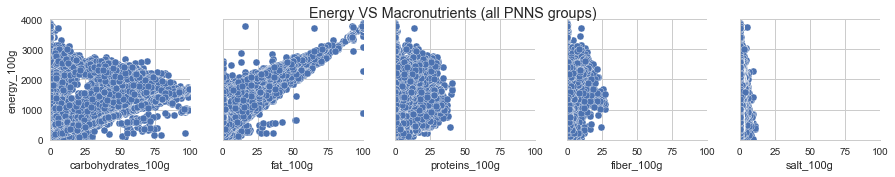

In [70]:
x_vars = [
    'carbohydrates_100g',
    'fat_100g',
    'proteins_100g',
    'fiber_100g',
    'salt_100g']

y_vars = ['energy_100g']

# Obtain scatter plots of the energy versus each macronutrients for all groups of food
g = sns.pairplot(df_nutrients, kind='scatter', x_vars=x_vars, y_vars=y_vars)
g.fig.suptitle('Energy VS Macronutrients (all PNNS groups)')
g.set(xlim=(0, 100))
g.set(ylim=(0, 4000))
plt.show()

We can see a linear correlation between energy and fats. In the carbohydrates scatter plot, we can also guess a linear correlation. It comes probably from some specific kind of food. Concerning proteins, fibers and salt, there is no evident visible correlations.

In the dataframe presenting the macronutrient breakdown by pnns groups, we can see that:

1. Fats tend to have essentially fats
2. Fruits tend to have essentially carbohydrates
3. There aren't kind of food that have essentially proteins in the same order than fruits and fat have for carbohydrates and fats respectively 
3. Legumes are well balanced food and contains carbohydrates, fats and proteins in good proportion

We will profit the  high ratio of fat and carbohydrates from fats and fruits to estimate their respective calorie intake. Then, we will deduce the protein calorie intake from legumes by substracting from their known energy the energy provided by fats and carbohydrates. 

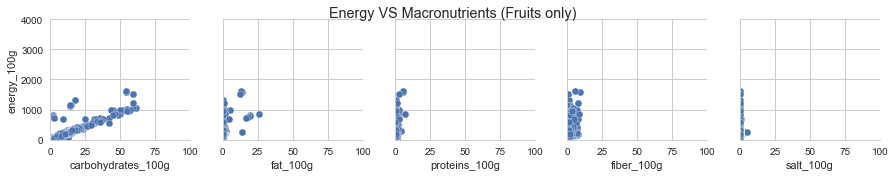

In [71]:
# Function to draw pairplots for a specifig pnns group 2
def pairplot_for_pnns_group(df, pnns_group, x_vars, y_vars, title, xlim=(0, 100), ylim=(0, 4000)):
    g = sns.pairplot(df[df.pnns_groups_2 == pnns_group], kind='scatter', x_vars=x_vars, y_vars=y_vars)
    g.fig.suptitle(title)
    g.set(xlim=xlim)
    g.set(ylim=ylim)
    plt.show()  
    
    
# Scatter plots of the energy versus each macronutrients for fruits only
pairplot_for_pnns_group(df_nutrients, 'Fruits', x_vars, y_vars, 'Energy VS Macronutrients (Fruits only)')

When considering fruits only, we have a clear linear correlation between energy and carbohydrates. We can compute a linear regression. The slope will give us an approximation of the carbohydrates calorie intake :

In [72]:
# Import the linear regression method from scipy.stats
from scipy.stats import linregress

# Convertion from kJ to kcal
kj_to_kcal = 0.239006

# Keep only fruits
df_fruits = df_nutrients[df_nutrients.pnns_groups_2 == 'Fruits'].copy()

# Compute the linear regression for fruits only between energy and carbohydrates
slope_carbohydrates, intercept_carbohydrates, r_value, p_value, std_err = linregress(x=df_fruits['carbohydrates_100g'], y=df_fruits['energy_100g'])

print("Linear regression equation [kJ]    : Energy = {} * Carbohydrates + {}".format(slope_carbohydrates, intercept_carbohydrates))
print("Linear regression equation [kcal]  : Energy = {} * Carbohydrates + {}".format(slope_carbohydrates * kj_to_kcal, intercept_carbohydrates * kj_to_kcal))
print("Carbohydrates Energy [kJ]   intake : {}".format(slope_carbohydrates))
print("Carbohydrates Energy [kcal] intake : {}".format(slope_carbohydrates * kj_to_kcal))

Linear regression equation [kJ]    : Energy = 18.17944673297133 * Carbohydrates + 20.697027373716082
Linear regression equation [kcal]  : Energy = 4.344996845860545 * Carbohydrates + 4.946713724482386
Carbohydrates Energy [kJ]   intake : 18.17944673297133
Carbohydrates Energy [kcal] intake : 4.344996845860545


**Simple rule:** 1 gram of carbohydrates provides about 4 kilocalories of energy.

Let's do the same for Fats products only :

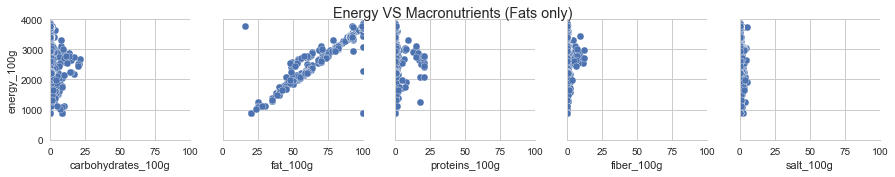

In [73]:
# Scatter plots of the energy versus each macronutrients for fats only
pairplot_for_pnns_group(df_nutrients, 'Fats', x_vars, y_vars, 'Energy VS Macronutrients (Fats only)')

We have a nice linear correlation between energy and fat.

In [74]:
# Keep only fats
df_fats = df_nutrients[df_nutrients.pnns_groups_2 == 'Fats'].copy()

# Compute the energy without the carbohydrates contribution (~ energy from fats)
df_fats['energy_fats_100g'] = df_fats.energy_100g - slope_carbohydrates * df_fats.carbohydrates_100g

# Compute the linear regression for fats only between energy (without carbohydrates contribution) and fats
slope_fats, intercept_fats, r_value, p_value, std_err = linregress(x=df_fats['fat_100g'], y=df_fats['energy_fats_100g'])

print("Linear regression equation [kJ]    : Energy = {} * Fats + {}".format(slope_fats, intercept_fats))
print("Linear regression equation [kcal]  : Energy = {} * Fats + {}".format(slope_fats * kj_to_kcal, intercept_fats *kj_to_kcal))
print("Fats Energy [kJ]   intake : {}".format(slope_fats))
print("Fats Energy [kcal] intake : {}".format(slope_fats * kj_to_kcal))

Linear regression equation [kJ]    : Energy = 34.66632988707724 * Fats + 221.19709401631553
Linear regression equation [kcal]  : Energy = 8.285460840990783 * Fats + 52.867432652463506
Fats Energy [kJ]   intake : 34.66632988707724
Fats Energy [kcal] intake : 8.285460840990783


**Simple rule:** 1 gram of fats provides about 8 kilocalories of energy.

We can know deduce from legumes the proteins calorie intake :

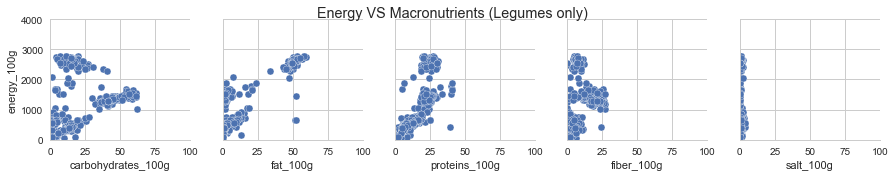

In [75]:
# Scatter plots of the energy versus each macronutrients for legumes only
pairplot_for_pnns_group(df_nutrients, 'Legumes', x_vars, y_vars, 'Energy VS Macronutrients (Legumes only)')

Interesting, we can see different clusters. It means that our Legumes PNNS Groups is too broad and could be splitted in multiple more specific subgroups.  
We can guess a linear correlation for the three macronutriens.

In [76]:
# Compute the linear regression for fruits only between energy and carbohydrates
df_legumes = df_nutrients[df_nutrients.pnns_groups_2 == 'Legumes'].copy()

# Compute the energy without the carbohydrates contribution
df_legumes['energy_proteins_100g'] = df_legumes.energy_100g \
                                     - slope_carbohydrates * df_legumes.carbohydrates_100g \
                                     - slope_fats * df_legumes.fat_100g

Before computing a linear regression, we should check if there is really a linear correlation between proteins and the energy we have just computed

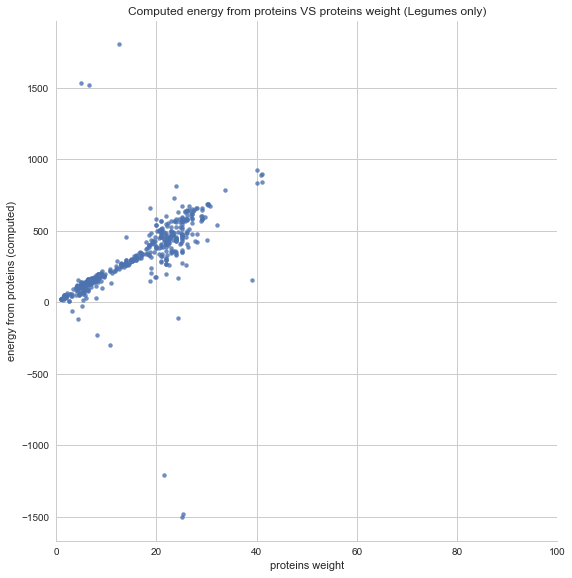

In [77]:
# Draw a scatterplot of energy from proteins VS proteins
sns.lmplot(data=df_legumes, 
           x='proteins_100g', 
           y='energy_proteins_100g', 
           fit_reg=False,
           scatter_kws={"marker": "D", "s": 20}, size=8)
plt.xlim(0, 100)
plt.xlabel('proteins weight')
plt.ylabel('energy from proteins (computed)')
plt.title("Computed energy from proteins VS proteins weight (Legumes only)")
plt.show()

In [78]:
# Compute the linear regression for legumes only between energy (without carbohydrates and fats contributions) and proteins
slope_proteins, intercept_proteins, r_value, p_value, std_err = linregress(x=df_legumes['proteins_100g'], y=df_legumes['energy_proteins_100g'])

print("Linear regression equation [kJ]    : Energy = {} * Fats + {}".format(slope_proteins, intercept_proteins))
print("Linear regression equation [kcal]  : Energy = {} * Fats + {}".format(slope_proteins * kj_to_kcal, intercept_proteins *kj_to_kcal))
print("Proteins Energy [kJ]   intake : {}".format(slope_proteins))
print("Proteins Energy [kcal] intake : {}".format(slope_proteins * kj_to_kcal))

Linear regression equation [kJ]    : Energy = 18.17220338074392 * Fats + 23.015888930256352
Linear regression equation [kcal]  : Energy = 4.343265641218081 * Fats + 5.50093554966485
Proteins Energy [kJ]   intake : 18.17220338074392
Proteins Energy [kcal] intake : 4.343265641218081


**Simple rule:** 1 gram of proteins provides about 4 kilocalories of energy

We used an empirical methods to discover the calorie ratio provided by carbohydrates, fats and proteins. It's tempting to say that the formula to compute the energy from the three macronutrients weight is the following:

`Energy [kJ]   = 18.179 * Carbohydrates [g] + 34.668 * Fats [g] + 18.236 * Proteins [g]`  

or

`Energy [kcal] = 4.345 * Carbohydrates [g] + 8.286 * Fats [g] + 4.359 * Proteins [g]`

And to easely remember it :

`Energy [kcal] = 8 * Fats [g] * 4 * Carbohydrates [g] +  + 4 * Proteins [g]`  (8/4/4 in the order of label sheet)

We can evaluate the quality of our very basic and empirical "model" by calculting the predicted energy from the model for each products and compare the deviation from the known energy. We will exclude foods groups used to build our "model".

In [79]:
# Keep only food not used during the modeling process
df_model_test = df_nutrients[~df_nutrients.pnns_groups_2.isin(['Fruits', 'Fats', 'Legumes'])].copy()

# Compute the expected energy
df_model_test['expected_energy_100g'] = slope_carbohydrates * df_model_test.carbohydrates_100g + \
                                        slope_fats * df_model_test.fat_100g + \
                                        slope_proteins * df_model_test.proteins_100g

# Compute the absolute value of the deviation in percent
df_model_test['energy_deviation'] = np.abs(df_model_test.expected_energy_100g - df_model_test.energy_100g) / df_model_test.energy_100g * 100

In [80]:
# Get deviation statistics
df_model_test.energy_deviation.describe()

count    33853.000000
mean         9.695481
std        119.589055
min          0.000224
25%          1.304611
50%          3.197429
75%          6.053431
max      15341.379823
Name: energy_deviation, dtype: float64

With a mean at +/- 10% and a median at about +/- 3%, it is not so bad for very empirical "model" !  
The 8/4/4 rules is a good approximation to remember at the supermarket :)

### Summary

It closes our last analysis topic. We have investigate about the macronutrient breakdown across various foods and used statistical independant t-test to check if observed macronutrients breakdown differences are significant are not. We have also investigate about the correlation between energy and each macronutrients (carbohydrates, fats and proteins). 

We have found that fibers and salt, even if indicated on each food labels do not contribute to energy or at least not in the same amplitude than carbohydrates, fats and proteins. We can remember the rules fats 8/carbohydrates 4/ proteins 4 kilocalories per gram.

# C. Text data

In this section, we want to find the five most common ingredients.

In [81]:
# Get some ingredients raw data
get_top_occurencies(data, 'ingredients_text', n=100)

,count,count %
ingredients_text,,
"Carbonated water, natural flavor.",222,0.06
Almonds.,219,0.06
Extra virgin olive oil.,202,0.06
Extra virgin olive oil,192,0.05
"Semolina (wheat), durum flour (wheat), niacin, ferrous sulfate (iron), thiamin mononitrate, riboflavin, folic acid.",184,0.05
Honey,150,0.04
Walnuts.,130,0.04
Pecans.,128,0.04
"Green beans, water, salt.",124,0.03


The data contain multiple langages, numbers (percentages, color codes), multiple nested enumeration lists of ingredients (separated with parenthesis, brackets, etc.), special characters (underscores, dots), different ingredients separators (comma, and, and/or, &).

We have a lot of cleaning to do. We don't have the same opportunity to build a dictionnary as we did for allergens. So we will tackle the langage cleaning by using only data from the USDA Database. We know that these data are controlled and standardized and that all of them contain list of ingredients. At worst, our answer will be the 5 most common ingredients in the US food products. 

In [82]:
# Build our dataframe by keeping only data with allergens
df = data[(data.source == 'usda') & (data.ingredients_text.notnull())]
df = df.reindex(columns=['product_name', 'ingredients_text', 'source'])

print('Number of observations: {}'.format(df.shape[0]))

Number of observations: 169661


### Some basic cleaning

Let's start by some basic cleaning like removing unwanted whitespaces, special characters, dots and put everything in lowercase :

In [83]:
# Everything in lowercase
df['ingredients'] = df.ingredients_text.str.lower()

# Strip whitespaces
df.ingredients = df.ingredients.str.strip()

# Replace multiple whitespaces by only one space
df.ingredients = df.ingredients.str.replace(r"\s+", " ")

# Remove whitespaces after comma
df.ingredients = df.ingredients.str.replace(r",\s+", ",")

# Remove * characters
df.ingredients = df.ingredients.str.replace(r"\*+\s*", "")

# Remove _ characters
df.ingredients = df.ingredients.str.replace(r"_+\s*", "")

# Remove trailing dots
df.ingredients = df.ingredients.str.replace(r"\.+$", "")

# Remove dots at the beginning
df.ingredients = df.ingredients.str.replace(r"^\.+", "")

get_top_occurencies(df, 'ingredients', 100)

,count,count %
ingredients,,
extra virgin olive oil,392,0.23
almonds,271,0.16
honey,246,0.14
"carbonated water,natural flavor",229,0.13
"semolina (wheat),durum flour (wheat),niacin,ferrous sulfate (iron),thiamin mononitrate,riboflavin,folic acid",185,0.11
walnuts,167,0.10
pecans,160,0.09
"green beans,water,salt",140,0.08
soybean oil,138,0.08


### Flatten the sublists

There are multiple nested list of ingredients in some products. We will flatten these lists by only replacing the list separators by comma ( (), [], {} ). We will also replace : and ; by comma to simplify the extraction of individual ingredients later : 

In [84]:
# Flatten the sublists by replacing (), [], {}, ;, : by comma
df.ingredients = df.ingredients.str.replace(r"\s*[\(\)\[\]\{\}:;]\s*", ",")

get_top_occurencies(df, 'ingredients', 100)

,count,count %
ingredients,,
extra virgin olive oil,392,0.23
almonds,271,0.16
honey,246,0.14
"carbonated water,natural flavor",229,0.13
"semolina,wheat,,durum flour,wheat,,niacin,ferrous sulfate,iron,,thiamin mononitrate,riboflavin,folic acid",186,0.11
walnuts,167,0.10
pecans,160,0.09
"green beans,water,salt",140,0.08
soybean oil,138,0.08


### And, and/or, &

We will also replace the enumeration words and, and/or, & by comma (between whitespaces and after a comma) :

In [85]:
# Remove and/or, and, & when it is between whitespaces
df.ingredients = df.ingredients.str.replace(r"\s+and/or\s+|\s+or\s+|\s+and\s+|\s+&\s+", ",")

# Remove and/or, and, & when it is just after a comma
df.ingredients = df.ingredients.str.replace(r",and/or\s+|,or\s+|,and\s+|,&\s+", ",")

### Numbers and Percentages

Here we will remove integers, real numbers and percentages when :

- at the beginnig of the ingredients list
- at the end of the ingredients list
- just after a comma
- just before a comma
- and in the middle of the text (surrounded by whitespaces)

In [86]:
# Remove percentages and real numbers
# -----------------------------------

# Remove when at the beginning 
df.ingredients = df.ingredients.str.replace(r"^\d+\.?\d+%?\s+", "")

# Remove when at the end
df.ingredients = df.ingredients.str.replace(r"\s+\d+\.?\d+%?$", "")

# Remove when just after a comma
df.ingredients = df.ingredients.str.replace(r",\d+\.?\d+%?\s+", ",")

# Remove when just before a comma
df.ingredients = df.ingredients.str.replace(r"\s+\d+\.?\d+%?,", ",")

# Remove when in the middle of the text (surrounded by whitespaces)
df.ingredients = df.ingredients.str.replace(r"\s+\d+\.?\d+%?\s+", " ")

# Remove integers percentages
# ---------------------------

# Remove when at the beginning 
df.ingredients = df.ingredients.str.replace(r"^\d+%\s+", "")

# Remove when at the end
df.ingredients = df.ingredients.str.replace(r"\s+\d%+$", "")

# Remove when just after a comma
df.ingredients = df.ingredients.str.replace(r",\d+&\s+", ",")

# Remove when just before a comma
df.ingredients = df.ingredients.str.replace(r"\s+\d+%,", ",")

# Remove when in the middle of the text (surrounded by whitespaces)
df.ingredients = df.ingredients.str.replace(r"\s+\d+%\s+", " ")


# Remove integers
# ---------------

# Remove when at the beginning 
df.ingredients = df.ingredients.str.replace(r"^\d+\s+", "")

# Remove when at the end
df.ingredients = df.ingredients.str.replace(r"\s+\d+$", "")

# Remove when just after a comma
df.ingredients = df.ingredients.str.replace(r",\d+\s+", ",")

# Remove when just before a comma
df.ingredients = df.ingredients.str.replace(r"\s+\d+,", ",")

# Remove when in the middle of the text (surrounded by whitespaces)
df.ingredients = df.ingredients.str.replace(r"\s+\d+\s+", " ")

### Last cleaning before ingredients extraction

During the previous cleaning, it's possible that we have reintroduce unwanted whitespaces, consecutive comma, comma at the beginning and end of the list :

In [87]:
# Cleaning: Strip whitespaces
df.ingredients = df.ingredients.str.strip()

# Cleaning: Replace multiple whitespaces by only one space
df.ingredients = df.ingredients.str.replace(r"\s+", " ")

# Cleaning: Remove whitespaces after comma
df.ingredients = df.ingredients.str.replace(r",\s+", ",")

# Cleaning: Remove whitespaces before comma
df.ingredients = df.ingredients.str.replace(r"\s+,", ",")

# Cleaning: Remove multiples consecutive comma
df.ingredients = df.ingredients.str.replace(r",+", ",")

# Cleaning: trailing comma
df.ingredients = df.ingredients.str.replace(r",$", "")

# Cleaning: comma at the beginning
df.ingredients = df.ingredients.str.replace(r"^,", "")

get_top_occurencies(df, 'ingredients', 100)

,count,count %
ingredients,,
extra virgin olive oil,422,0.25
almonds,271,0.16
honey,247,0.15
"carbonated water,natural flavor",241,0.14
"pasteurized milk,cheese culture,salt,enzymes,annatto,vegetable color",188,0.11
"semolina,wheat,durum flour,wheat,niacin,ferrous sulfate,iron,thiamin mononitrate,riboflavin,folic acid",187,0.11
walnuts,168,0.10
pecans,160,0.09
"green beans,water,salt",160,0.09


### Extration of each individual ingredients

We can now extract individual ingredients and drop the potential duplicates :

In [88]:
# Build a DataFrame with one ingredients per row 
df_ingredients = df.ingredients[df.source == 'usda'].str.extractall(r"(?P<ingredient>[^,]+)")

# Reset the index
df_ingredients.reset_index(inplace=True)

# Drop the match column
df_ingredients.drop('match', axis=1, inplace=True)

# Drop duplicates
df_ingredients.drop_duplicates(subset=['code', 'ingredient'], inplace=True)

# Set again the code as the index
df_ingredients.set_index('code', inplace=True)

df_ingredients.head(5)

,ingredient
code,
0000000004530,bananas
0000000004530,vegetable oil
0000000004530,coconut oil
0000000004530,corn oil
0000000004530,palm oil


### Get the most common ingredients

In [89]:
# Get the twenty first common ingredients
get_top_occurencies(df_ingredients, 'ingredient', 15)

,count,count %
ingredient,,
salt,79665,3.78
sugar,64148,3.04
water,60105,2.85
citric acid,33111,1.57
riboflavin,21382,1.01
folic acid,21337,1.01
niacin,20406,0.97
corn syrup,19009,0.90
wheat flour,18045,0.86


It's not surprising to find salt, sugar and water. Acid citric is used as an taste exausters and riboflavin, also known as vitamin B2 is often used as a food coloring (denominated E101 in Europe). 

Flour and oil appears in this list, it could be interesting to extract each words and look at the most common words in ingredients list :

In [90]:
# Extraction of each words
df_ingredient_words = df_ingredients.ingredient.str.extractall(r"(?P<word>[^\s]+)")

# Most common words
get_top_occurencies(df_ingredient_words, 'word', 20)

,count,count %
word,,
salt,101123,2.50
oil,90027,2.22
sugar,89254,2.20
acid,88533,2.19
flour,75049,1.85
water,74982,1.85
organic,74221,1.83
corn,69455,1.72
milk,62019,1.53


At a higher level, we could say that the most common ingredients are :

- salt
- oils
- sugar
- acids (taste exausters, food coloring and also some vitamins)
- flour
- water

### Oils, and Acids and Flours

For curiosity, let's get some details about the usage of oils, acids and flours :

In [91]:
# Most common used oils
df_oils = df_ingredients[df_ingredients.ingredient.str.contains('oil')]
get_top_occurencies(df_oils, 'ingredient', 5)

,count,count %
ingredient,,
soybean oil,14397,15.26
canola oil,9229,9.78
palm oil,8883,9.42
vegetable oil,7767,8.23
sunflower oil,5857,6.21


In [92]:
# Most common used acids
df_acids = df_ingredients[df_ingredients.ingredient.str.contains('acid')]
get_top_occurencies(df_acids, 'ingredient', 5)

,count,count %
ingredient,,
citric acid,33111,35.70
folic acid,21337,23.01
ascorbic acid,8822,9.51
lactic acid,5353,5.77
malic acid,3782,4.08


- citric acid : used as taste exhauster
- folic acid : synthetic form of B vitamin. Since 1998, folic acid has been added to cold cereals, flour, breads, pasta, bakery items, cookies, and crackers, as required by federal law

In [93]:
# Most common used flour
df_flour = df_ingredients[df_ingredients.ingredient.str.contains('flour')]
get_top_occurencies(df_flour, 'ingredient', 5)

,count,count %
ingredient,,
wheat flour,18045,23.94
malted barley flour,5803,7.70
enriched wheat flour,5048,6.70
enriched flour,4490,5.96
flour,3399,4.51


### Summary

Our investigation about the most used ingrendients in food give results not particularly encouraging. Taste exhausters, food coloring, added sugar are in the food we eat every day. We have used US data only in our analysis so we could try to believe it's not the case in our countries but by executing the same code for the openfoodfacts database, we obtain similar/near results (cleaning should be improved to treat the french data but even without it the tendency is already visible).

# D. Time-series analysis

In this section, we will investigate about the mean time difference between the `created_datetime` and the `last_modified_datetime` variables. We will also investigate about the mean number of created items per month over the timeline of the data.

### Time difference between creation and modification

In this analysis, it makes no sense to keep the data from the usda and foodrepo import because they have been imported in 2017. We will also restrict our data to the observation with the complete state only, so products for which there is a good probability they have been scanned with a real will to be completed afterwards (remember the two steps collection process with mobile apps)

In [94]:
# Add a variable with the time difference (TimeDelta)
data['deltatime'] = data.last_modified_datetime - data.created_datetime

# Add a variable with the time difference in seconds
data['deltatime_in_seconds'] = data['deltatime'].map(lambda x: x.total_seconds())

# Keep only data from the openfoodfact project with the complete state
df_time = data.loc[(data.source == 'openfoodfacts') & (df_states.complete), ['created_datetime', 'last_modified_datetime', 'deltatime', 'deltatime_in_seconds']]

print('DataFrame shape: {}'.format(df_time.shape))
df_time.head()

DataFrame shape: (67905, 4)


,created_datetime,last_modified_datetime,deltatime,deltatime_in_seconds
code,,,,
0000000290616,2017-01-16 22:32:58,2017-01-16 22:42:22,0 days 00:09:24,564.0
0000000394710,2017-01-15 16:22:50,2017-01-15 17:24:00,0 days 01:01:10,3670.0
0000001938067,2017-01-15 17:32:08,2017-01-15 18:29:32,0 days 00:57:24,3444.0
0000004302544,2017-03-02 14:28:16,2017-03-02 14:41:27,0 days 00:13:11,791.0
0000007020254,2015-01-01 22:09:53,2017-09-02 18:18:21,974 days 20:08:28,84226108.0


In [95]:
# Get some statistics
df_time.deltatime.describe()

count                       67905
mean     366 days 19:32:19.213297
std      455 days 21:46:32.364981
min               0 days 00:00:38
25%               1 days 08:15:22
50%             159 days 13:34:38
75%             620 days 02:03:25
max            2033 days 13:40:59
Name: deltatime, dtype: object

Given the standard deviation, the mean is not very usefull. The quartiles are more interesting. 25% of the products are completed during the 32 hours after their creation in the database and 50% during the next 5 months. Note that the quartiles describe a strongly skewed right distribution. It's easier to see it with a boxplot :

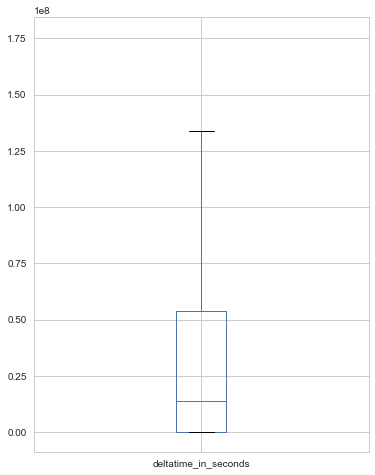

In [96]:
# Draw a boxplot
df_time.deltatime_in_seconds.plot.box(figsize=(6, 8))
plt.show()

Let's look at the distribution of the data. Because the range of the data are very large, we will compute the log10 of the time difference in seconds and plot its histogram :

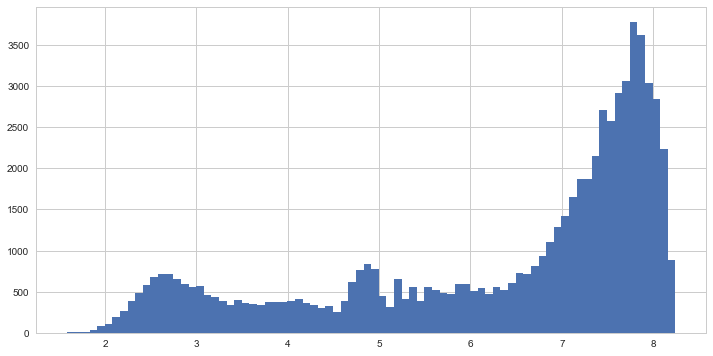

In [97]:
# Compute the log10 of the time difference
deltatime_in_sec_log = np.log10(df_time.deltatime_in_seconds)

# Draw the histrogram
plt.figure(figsize=(12, 6))
deltatime_in_sec_log.hist(bins=80)
plt.show()

This histrogram seems to be the result of multiple behaviours :

1. The first *bumb* between 100s and 1000s seconds (peak around 7min) are not real updates but surely people adding products from the website form and saving multiple times their works during the process.
2. We can guess an another *peak* centered around 4.1 (about 4 hours)  that could describe a morning shop inventory and afternoon filling process
3. There is a strong peak around 4.8-4.9 that corresponds to about 1 day time difference: 1 day inventory, filling process the next day 
4. We can guess another distribution centered around 5.8 corresponding to about one week. A big shop inventory and then many days to complete the new collected products.
5. The huge spike centered around 7.8 (about 730 days, 365 days is 7.5) could reflect the fact that there are not enough ressources to complete all the data acquired during shop inventories. The backlog is completed over time. It can also be products completed long ago but updated because someone send a new picture for example.

Note: We are summarizing the data with products created between 2012 and 2017. The histrogramm shape remains the same if we take for example only product created since 2014.

### The mean number of created items per month over the timeline

In this section, we will investigate about the mean number of created items per month over the timeline of the data.

Let's first define a function that will allow us answer this question for the following subset of the data:

- All the openfoodfacts products
- All the openfoodfacts products that have been completed (could give information about the work force hiring)
- All the openfoodfacts products that have been created by anonymous contributors (could give information about people behaviour)

In [98]:
# Function to comupute the number of created items per month and the mean number of created items per month over the timeline
def mean_number_of_created_items_per_month(s, start_date, end_date):
    # Get the number of created items per day with the date as the index
    per_day = s.groupby(s.dt.date).size()
    per_day.index = pd.to_datetime(per_day.index)
    
    # Keep only the range date
    per_day = per_day[start_date:end_date]
    
    # We want the number of items created per month, let's resample the time-series
    per_month = per_day.resample('M').sum()
    
    # We now want to compute the mean of created items per month
    mean_per_month = per_month.groupby(per_month.index.month).mean() 
    mean_per_month.index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    return (per_month, mean_per_month.astype(int))

In [99]:
# Build the subset dataframe
# ----

# All openfoodfacts products
df_created_openfoodfacts = data.loc[data.source == 'openfoodfacts', 'created_datetime']

# Only completed openfoodfacts products
df_created_openfoodfacts_complete = data.loc[(data.source == 'openfoodfacts') & (df_states.complete), 'created_datetime']

# Only openfoodfacts contributors (anonymous contributors) products
df_created_contributors = data.loc[data.creator == 'openfoodfacts-contributors', 'created_datetime']

The Open Food Facts project is born in 2012, we will clip the first months of the project and take data from the 1st August 2012 to the 31st August 2017 (November 2017 is not complete in our data set).

In [100]:
# Compute the mean number per month for each dataframe (we set the start and end dates to full August-August years)
per_month_openfoodfacts, mean_openfoodfacts = mean_number_of_created_items_per_month(df_created_openfoodfacts, '2012-08-01', '2017-08-31')
per_month_openfoodfacts_complete, mean_openfoodfacts_complete = mean_number_of_created_items_per_month(df_created_openfoodfacts_complete, '2012-08-01', '2017-08-31')
per_month_contributors, mean_contributors = mean_number_of_created_items_per_month(df_created_contributors, '2012-08-01', '2017-08-31')

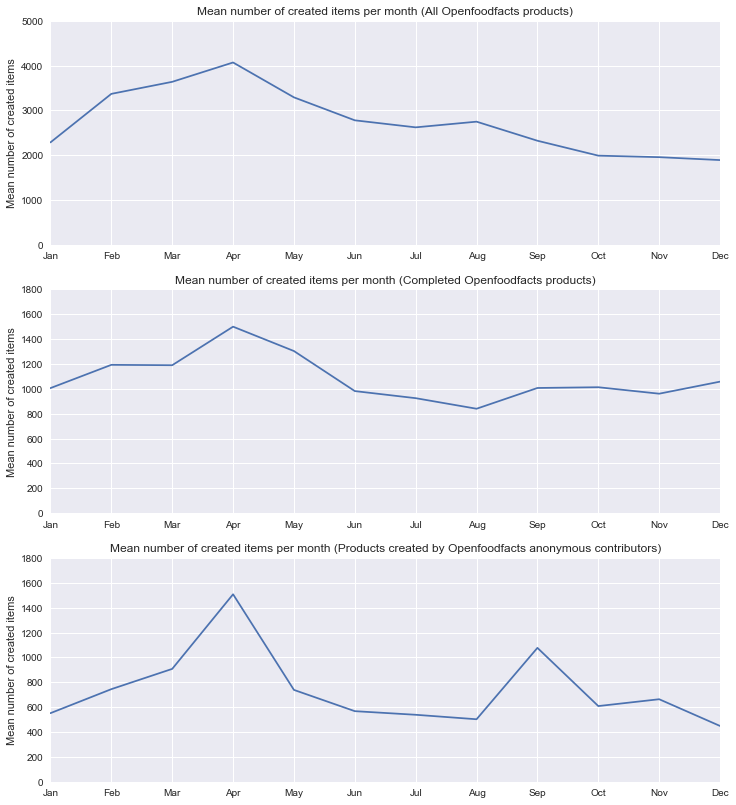

In [101]:
xticks = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Plot the mean number of created items per month
sns.set()

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(12, 14))
mean_openfoodfacts.plot(ax=ax1)
ax1.set_xlim(0, 11)
ax1.set_xticks(np.arange(12))
ax1.set_xticklabels(xticks)
ax1.set_ylim(0, 5000)
ax1.set_title('Mean number of created items per month (All Openfoodfacts products)')
ax1.set_ylabel('Mean number of created items')

mean_openfoodfacts_complete.plot(ax=ax2)
ax2.set_xlim(0, 11)
ax2.set_xticks(np.arange(12))
ax2.set_xticklabels(xticks)
ax2.set_ylim(0, 1800)
ax2.set_title('Mean number of created items per month (Completed Openfoodfacts products)')
ax2.set_ylabel('Mean number of created items')

mean_contributors.plot(ax=ax3)
ax3.set_xlim(0, 11)
ax3.set_xticks(np.arange(12))
ax3.set_xticklabels(xticks)
ax3.set_ylim(0, 1800)
ax3.set_title('Mean number of created items per month (Products created by Openfoodfacts anonymous contributors)')
ax3.set_ylabel('Mean number of created items')

plt.show()

In the B.1 section, we observed that the number of items created per month tend to grow quadratically. It means that the standard deviations of the means are in the same order that the means themself, does it make really a sense to compare the means in these conditions ? We have few data per month, their distribution can not be normal, so we can't compute t-test... The question remains open and the following interpretation are dared...

It's tempting to interpret these plots :

- An overall correlation with the weather: growth during bad weather month and less items created during nice days
- the growth at the beginning of the year could be correlated with the new years good resolution for diet. It is also probably the inventory period for shops so volonteers have more work during this period of the year
- During summer holidays, less work force 

The last plot from the anonymous contributors could reflect the will to be fit for the nice days and preparation for the new outdoor sport season, etc.


P.S. I have the feeling to miss something in this part, normalizing the data ? per year to compare month activity by ridding of/limiting the growth over year ?...

# E. Build a database

We will build a database with only some variables from the original csv file. The schema will be simple, only three tables. The food facts will be stored in their stacked form to avoid a table with a lot of NULL values. It is also a good way to keep our schema versatile. The schema don't have to be updated to handle new facts :

- **products** that contains the code, product name and pnns groups
- **facts** that contains the list of facts with some details about them like fact name, unit, type of fact
- **product facts** that contains the fact values for the corresponding product (product_code) and fact (fact_id)

In [102]:
# Import the sqlite library
import sqlite3

# Connect to the database
db = sqlite3.connect('openfoodfacts.sqlite')

# Get a cursor
cursor = db.cursor()

## E.1 Tables creation

### Create the facts table

Let's create the facts table that will contains the facts *headers*.  
Here is a fact record example:

- id: 7
- name: Saturated fat
- type: fat
- unit: g
- etl_source_name: saturated-fat_100g

In [103]:
# Drop the facts table if it already exists (easy to iterate in development)
cursor.execute('DROP TABLE IF EXISTS facts;')

# Create the facts table
query = '''
CREATE TABLE facts
(
    id INTEGER PRIMARY KEY,
    name TEXT NOT NULL,
    type TEXT NOT NULL,
    unit TEXT NOT NULL,
    etl_source_name NOT NULL
);
'''
cursor.execute(query)

### Create the products table

Let's create the products table that will contains the foods with some of their details.  
Here is a product record example:

- code: 3415580503518
- product_name: Pot Crème Glacée vanilla
- pnns_groups_1: Milk and dairy products
- pnns_groups_2: Ice cream
- source: openfoodfacts

In [104]:
# Drop the products table if it exists (easy to iterate in development)
cursor.execute('DROP TABLE IF EXISTS products;')

# Create the products table
query = '''
CREATE TABLE products
(
    code TEXT PRIMARY KEY,
    product_name TEXT NOT NULL,
    pnns_groups_1 TEXT NOT NULL,
    pnns_groups_2 TEXT NOT NULL,
    source TEXT NOT NULL
);
'''
cursor.execute(query)

### Create the product facts table

Let's create the product facts table that will contains the facts values, stored in a stacked form, with a product code referencing the product stored in the products table and a fact ID referencing the corresponding fact stored in the facts table.  

Here is a product fact record example:

- product_code: 3415580503518 
- fact_id: 3 (sugars) 
- value: 18.8

In [105]:
# Drop the product facts table if it exists (easy to iterate in development)
cursor.execute('DROP TABLE IF EXISTS product_facts;')

# Create the product facts table
query = '''
CREATE TABLE product_facts
(
    product_code TEXT NOT NULL,
    fact_id INTEGER NOT NULL,
    value REAL NOT NULL,
    PRIMARY KEY(product_code, fact_id),
    FOREIGN KEY (product_code) REFERENCES products (code)
        ON DELETE CASCADE ON UPDATE NO ACTION,
    FOREIGN KEY (fact_id) REFERENCES facts (id)
        ON DELETE CASCADE ON UPDATE NO ACTION
);
'''
cursor.execute(query)

We have two foreign keys referecing the products and facts tables. We have also set actions on deletion that mean if a a product (or fact) is deleted, product facts for this product (or fact) will be deleted automatically (cascade delete).

## E.2 Tables loading

We must now load the tables. We will load the data from the `df_nutrients` dataframe we used during the nutrients analysis :

In [106]:
# Show the data to load
df_nutrients.head()

,product_name,pnns_groups_1,pnns_groups_2,source,energy_100g,carbohydrates_100g,sugars_100g,starch_100g,polyols_100g,fat_100g,saturated-fat_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,trans-fat_100g,proteins_100g,casein_100g,serum-proteins_100g,fiber_100g,salt_100g
code,,,,,,,,,,,,,,,,,,,
0010596641075,"D' Sabor, Aloe Vera Juice Drink, Pineapple",Beverages,Artificially sweetened beverages,usda,117.0,7.60,7.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04318
0010596641198,"D' Sabor, Aloe Vera Juice Drink",Beverages,Artificially sweetened beverages,usda,117.0,7.60,7.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04318
0011152296081,Original Aloe Vera Drink,Beverages,Artificially sweetened beverages,usda,50.0,3.33,3.33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.03810
0011152296098,Aloe Vera Drink,Beverages,Artificially sweetened beverages,usda,50.0,3.33,3.33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.05334
0022652192070,"Parrot, Aloe Vera Drink, Aloe Strawberry",Beverages,Artificially sweetened beverages,usda,155.0,9.17,4.17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02032


### Load the facts table

Here, we simply build a DataFrame by hand and load it in the fact table with the `to_sql()` method:

In [107]:
df_facts = pd.DataFrame([
    [1,  'Energy', 'energy', 'kJ', 'energy_100g'],
    [2,  'Carbohydrates', 'carbohydrates', 'g', 'carbohydrates_100g'],
    [3,  'Sugars', 'carbohydrates', 'g', 'sugars_100g'],
    [4,  'Starch', 'carbohydrates', 'g', 'starch_100g'],
    [5,  'Polyols', 'carbohydrates', 'g', 'polyols_100g'],
    [6,  'Fat', 'fat', 'g', 'fat_100g'],
    [7,  'Saturated fat', 'fat', 'g', 'saturated-fat_100g'],
    [8,  'Monounsaturated fat', 'fat', 'g', 'monounsaturated-fat_100g'],
    [9,  'Polyunsaturated fat', 'fat', 'g', 'polyunsaturated-fat_100g'],
    [10, 'Trans fat', 'fat', 'g', 'trans-fat_100g'],
    [11, 'Proteins', 'proteins', 'g', 'proteins_100g'],
    [12, 'Casein', 'proteins', 'g', 'casein_100g'],
    [13, 'Serum proteins', 'proteins', 'g', 'serum-proteins_100g'],
    [14,  'Fiber', 'fiber', 'g', 'fiber_100g'],
    [15, 'Salt', 'salt', 'g', 'salt_100g'],
], columns=['id', 'name', 'type', 'unit', 'etl_source_name'])


# Insert the data in the facts database table
df_facts.to_sql(name='facts', con=db, if_exists='replace', index=False)

# Check the loading
query = '''
SELECT *
FROM
    facts
WHERE
    type = 'fat'
ORDER BY
    name ASC
LIMIT 5;
'''
pd.read_sql_query(query, db)

,id,name,type,unit,etl_source_name
0,6,Fat,fat,g,fat_100g
1,8,Monounsaturated fat,fat,g,monounsaturated-fat_100g
2,9,Polyunsaturated fat,fat,g,polyunsaturated-fat_100g
3,7,Saturated fat,fat,g,saturated-fat_100g
4,10,Trans fat,fat,g,trans-fat_100g


### Load the products table

The products loading is also done with the help of the `to_sql()` method. But first, we must build a dataframe with only the products table variables.

In [108]:
# Get a dataframe with only the corresponding products table variables
df_products = df_nutrients.reindex(columns=['product_name', 'pnns_groups_1', 'pnns_groups_2', 'source'])
df_products.reset_index(inplace=True)
df_products.head()

,code,product_name,pnns_groups_1,pnns_groups_2,source
0,0010596641075,"D' Sabor, Aloe Vera Juice Drink, Pineapple",Beverages,Artificially sweetened beverages,usda
1,0010596641198,"D' Sabor, Aloe Vera Juice Drink",Beverages,Artificially sweetened beverages,usda
2,0011152296081,Original Aloe Vera Drink,Beverages,Artificially sweetened beverages,usda
3,0011152296098,Aloe Vera Drink,Beverages,Artificially sweetened beverages,usda
4,0022652192070,"Parrot, Aloe Vera Drink, Aloe Strawberry",Beverages,Artificially sweetened beverages,usda


In [109]:
# Insert the data in the products database table
df_products.to_sql(name='products', con=db, if_exists='replace', index=False)

# Check to loading
query = '''
SELECT *
FROM
    products
WHERE
    pnns_groups_1 = 'Fruits and vegetables'
    AND pnns_groups_2 = 'Dried fruits'
LIMIT 5;
'''
pd.read_sql_query(query, db)

,code,product_name,pnns_groups_1,pnns_groups_2,source
0,0014113230018,Almonds,Fruits and vegetables,Dried fruits,openfoodfacts
1,0031200949271,Craisins,Fruits and vegetables,Dried fruits,openfoodfacts
2,0041143029107,Natural California Raisins,Fruits and vegetables,Dried fruits,openfoodfacts
3,00428996,Nut Collection,Fruits and vegetables,Dried fruits,openfoodfacts
4,0049022556096,Raisins (California Sun Dried),Fruits and vegetables,Dried fruits,openfoodfacts


### Load the product facts table

To load the product facts, some intermediate steps are required. We are starting with facts as variables (unstacked form) and we want to store the data on a stack form in the database (one fact per observation, so multiple rows for each product):

1. Stack the product facts
    - keep only the numerical variables
    - stack the data
    - reset the index
    - rename the columns after the stack for more clarity
2. Merge the product facts with the facts dataframe to have the corresponding fact id
    - rename the columns according to the product facts table
3. Load the products facts in the database with the `to_slq()` method

In [110]:
# Prepare the data for loading in the database (stacked form, merge with the facts dataframe to have the fact id)
df_product_facts = df_nutrients \
    .select_dtypes('number') \
    .stack() \
    .reset_index() \
    .rename(columns={'level_1': 'fact', 0: 'value'}) \
    .merge(df_facts, how='inner', left_on='fact', right_on='etl_source_name') \
    .rename(columns={'code': 'product_code', 'id': 'fact_id'}) \
    .sort_values(['product_code', 'type', 'name']) \
    
df_product_facts.head(10)

,product_code,fact,value,fact_id,name,type,unit,etl_source_name
66197,0000000394710,carbohydrates_100g,54.1,2,Carbohydrates,carbohydrates,g,carbohydrates_100g
175616,0000000394710,polyols_100g,0.0,5,Polyols,carbohydrates,g,polyols_100g
139143,0000000394710,starch_100g,0.0,4,Starch,carbohydrates,g,starch_100g
102670,0000000394710,sugars_100g,28.1,3,Sugars,carbohydrates,g,sugars_100g
29724,0000000394710,energy_100g,1520.0,1,Energy,energy,kJ,energy_100g
212089,0000000394710,fat_100g,14.4,6,Fat,fat,g,fat_100g
285035,0000000394710,monounsaturated-fat_100g,0.0,8,Monounsaturated fat,fat,g,monounsaturated-fat_100g
321508,0000000394710,polyunsaturated-fat_100g,0.0,9,Polyunsaturated fat,fat,g,polyunsaturated-fat_100g
248562,0000000394710,saturated-fat_100g,0.0,7,Saturated fat,fat,g,saturated-fat_100g
357981,0000000394710,trans-fat_100g,0.0,10,Trans fat,fat,g,trans-fat_100g


In [111]:
# Insert the data in the product facts database table
df_product_facts.loc[:, ['product_code', 'fact_id', 'value']] \
                .to_sql(name='product_facts', con=db, if_exists='replace', index=False)

# Check to loading
query = '''
SELECT *
FROM
    product_facts
LIMIT 5
'''
pd.read_sql_query(query, db)

,product_code,fact_id,value
0,0000000394710,2,54.1
1,0000000394710,5,0.0
2,0000000394710,4,0.0
3,0000000394710,3,28.1
4,0000000394710,1,1520.0


## E.3 Execute some queries

### Simple View as the original data source

From the database, we can reconstruct a view similar to the original csv file :

1. Get the products with all the needed descriptive variables and store the result in a dataframe
2. Get the facts as stored in the database (stack form) and store the result in a dataframe
3. Pivot the facts result to have one fact per column
4. Merge the two dataframes

In [112]:
# Get the products
query_products = '''
SELECT
    p.code AS Code,
    p.product_name AS Name,
    p.pnns_groups_1 AS 'PNNS Group 1',
    p.pnns_groups_2 AS 'PNNS Group 2',
    p.source AS Source
FROM
    products AS p
ORDER BY
    p.code ASC
'''
df_products = pd.read_sql_query(query_products, db)

# Get the facts and pivot the result to have one column for each fact (as the original csv file)
query_facts = '''
SELECT
    pf.product_code AS Code,
    f.name AS 'Fact',
    pf.value AS 'Value'
FROM
    product_facts AS pf
    JOIN facts AS f ON f.id = pf.fact_id
'''
df_facts = pd.read_sql_query(query_facts, db) \
             .pivot(index='Code', columns='Fact', values='Value')

# Create the view by merging the two dataframes
view = df_products.merge(df_facts, how='inner', left_on='Code', right_on='Code')      
view.head()

,Code,Name,PNNS Group 1,PNNS Group 2,Source,Carbohydrates,Casein,Energy,Fat,Fiber,Monounsaturated fat,Polyols,Polyunsaturated fat,Proteins,Salt,Saturated fat,Serum proteins,Starch,Sugars,Trans fat
0,0000000394710,Danoises à la cannelle roulées,Sugary snacks,Biscuits and cakes,openfoodfacts,54.1,0.0,1520.0,14.4,2.05,0.00,0.0,0.00,4.79,0.922000,0.0,0.0,0.0,28.1,0.000
1,0000001938067,Chaussons tressés aux pommes,Sugary snacks,Biscuits and cakes,openfoodfacts,38.7,0.0,1090.0,10.7,2.00,3.33,0.0,5.33,3.33,0.647000,2.0,0.0,0.0,24.7,0.667
2,0000007020254,Root Beer,Beverages,Sweetened beverages,openfoodfacts,14.2,0.0,215.0,0.0,0.00,0.00,0.0,0.00,0.00,0.061600,0.0,0.0,0.0,13.6,0.000
3,0000027533048,Luxury Christmas Pudding,Sugary snacks,Biscuits and cakes,openfoodfacts,54.2,0.0,1284.0,7.0,4.70,0.00,0.0,0.00,3.90,0.199898,3.6,0.0,0.0,44.0,0.000
4,0000040608754,"Pepsi, Nouveau goût !",Beverages,Sweetened beverages,openfoodfacts,10.4,0.0,177.0,0.0,0.00,0.00,0.0,0.00,0.00,0.025400,0.0,0.0,0.0,10.4,0.000


### Aggregation Query

Here is an example of an aggregation query.  
We compute the mean of fat and its breakdowns per food categories (PNNS Groups 1 & 2) 

In [113]:
query = '''
SELECT
    p.pnns_groups_1 AS 'PNNS Group 1',
    p.pnns_groups_2 AS 'PNNS Group 2',
    f.name AS 'Name',
    AVG(pf.value) AS 'Average value'
FROM
    products AS p
    JOIN product_facts AS pf ON p.code = pf.product_code
    JOIN 
    (
        SELECT
            id,
            name
        FROM
            facts
        WHERE
            type IN ('fat')
    ) AS f ON f.id = pf.fact_id
GROUP BY
    p.pnns_groups_1,
    p.pnns_groups_2,
    f.name
ORDER BY
    p.pnns_groups_1 ASC,
    p.pnns_groups_2 ASC,
    f.id ASC
'''
pd.read_sql_query(query, db)

,PNNS Group 1,PNNS Group 2,Name,Average value
0,Beverages,Artificially sweetened beverages,Fat,0.092595
1,Beverages,Artificially sweetened beverages,Saturated fat,0.022976
2,Beverages,Artificially sweetened beverages,Monounsaturated fat,0.001905
3,Beverages,Artificially sweetened beverages,Polyunsaturated fat,0.004286
4,Beverages,Artificially sweetened beverages,Trans fat,0.000000
5,Beverages,Fruit juices,Fat,0.132877
6,Beverages,Fruit juices,Saturated fat,0.032928
7,Beverages,Fruit juices,Monounsaturated fat,0.000096
8,Beverages,Fruit juices,Polyunsaturated fat,0.000096
9,Beverages,Fruit juices,Trans fat,0.000000


# F. Finding correlations

In this section, we will try to identify the variables which most affect the nutritional score and find correlation between them. 

Let's make some guesses; we are asked to rate food and give them a score, which criteria could help us to do the job ?

- probably kind of food, it sounds better to eat fruits & vegatables than sweets
- macronutrients composition
- energy maybe
- other (micronutrients composition, presence or absence of some specific facts, etc.)

For this analysis, we will reuse the DataFrame `df_nutrients` from the section B.3; it allow us to group the foods by pnns groups and we have the macronutrient fact and their first breakdown level.

First let's build our DataFrame from `df_nutrients` and add the `nutrition-score-fr_100g` and `nutrition_grade_fr ` variables :

In [114]:
# Merge DataFrames to have the nutrition score and nutrition grade
df_corr = df_nutrients.merge(data.loc[:, ['nutrition-score-fr_100g', 'nutrition_grade_fr']], 
                             how='inner', 
                             left_index=True, 
                             right_index=True)

# Drop observation with missing score and/or grade
df_corr.dropna(subset=['nutrition-score-fr_100g', 'nutrition_grade_fr'], inplace=True)

df_corr.head(5)

,product_name,pnns_groups_1,pnns_groups_2,source,energy_100g,carbohydrates_100g,sugars_100g,starch_100g,polyols_100g,fat_100g,...,monounsaturated-fat_100g,polyunsaturated-fat_100g,trans-fat_100g,proteins_100g,casein_100g,serum-proteins_100g,fiber_100g,salt_100g,nutrition-score-fr_100g,nutrition_grade_fr
code,,,,,,,,,,,,,,,,,,,,,
0010596641075,"D' Sabor, Aloe Vera Juice Drink, Pineapple",Beverages,Artificially sweetened beverages,usda,117.0,7.60,7.60,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04318,10.0,e
0010596641198,"D' Sabor, Aloe Vera Juice Drink",Beverages,Artificially sweetened beverages,usda,117.0,7.60,7.60,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04318,10.0,e
0011152296081,Original Aloe Vera Drink,Beverages,Artificially sweetened beverages,usda,50.0,3.33,3.33,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.03810,5.0,c
0011152296098,Aloe Vera Drink,Beverages,Artificially sweetened beverages,usda,50.0,3.33,3.33,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.05334,5.0,c
0022652192070,"Parrot, Aloe Vera Drink, Aloe Strawberry",Beverages,Artificially sweetened beverages,usda,155.0,9.17,4.17,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02032,9.0,d


### Nutrition Score & Nutrition Grade

Now, let's get some statistics about the score and grade variables :

In [115]:
# Get Nutrition score statistics
df_corr.loc[:, ['nutrition-score-fr_100g', 'nutrition_grade_fr']].describe(include='all')

,nutrition-score-fr_100g,nutrition_grade_fr
count,35953.000000,35953
unique,NaN,5
top,NaN,a
freq,NaN,8715
mean,6.639418,NaN
std,8.913824,NaN
min,-14.000000,NaN
25%,0.000000,NaN
50%,5.000000,NaN
75%,14.000000,NaN


The nutrition score has a range of value from -14 to 32 (-15 to 40 in the overall data), with a median at 5. All quartiles are integers, so it seems to be a discrete variable. Its scale looks weird... The nutrition grade is a classification variable with 5 unique value, the top occurence is 'a'.

Let's just look at the distinct value these variables can take :

In [116]:
# Look at the distinct values
print('Nutrition Score distinct values:\n{}\n'.format(df_corr['nutrition-score-fr_100g'].unique()))
print('Nutrition Score distinct values:\n{}'.format(df_corr['nutrition_grade_fr'].unique()))

Nutrition Score distinct values:
[ 10.   5.   9.   2.  13.   4.  12.   7.  -1.   3.   1.   8.  16.  20.
   6.   0.  -3.  11.  -2.  -5.  -4.  -6.  14.  15.  17.  18.  19.  27.
  -7.  21.  23.  24.  29.  30.  22.  25. -10.  -9.  -8. -12. -11. -13.
  26.  28. -14.  32.]

Nutrition Score distinct values:
['e' 'c' 'd' 'b' 'a']


It confirms that the nutrition score is a discrete variable.  
Let's look at their distribution and see if score and grade are related or two different scoring methods :

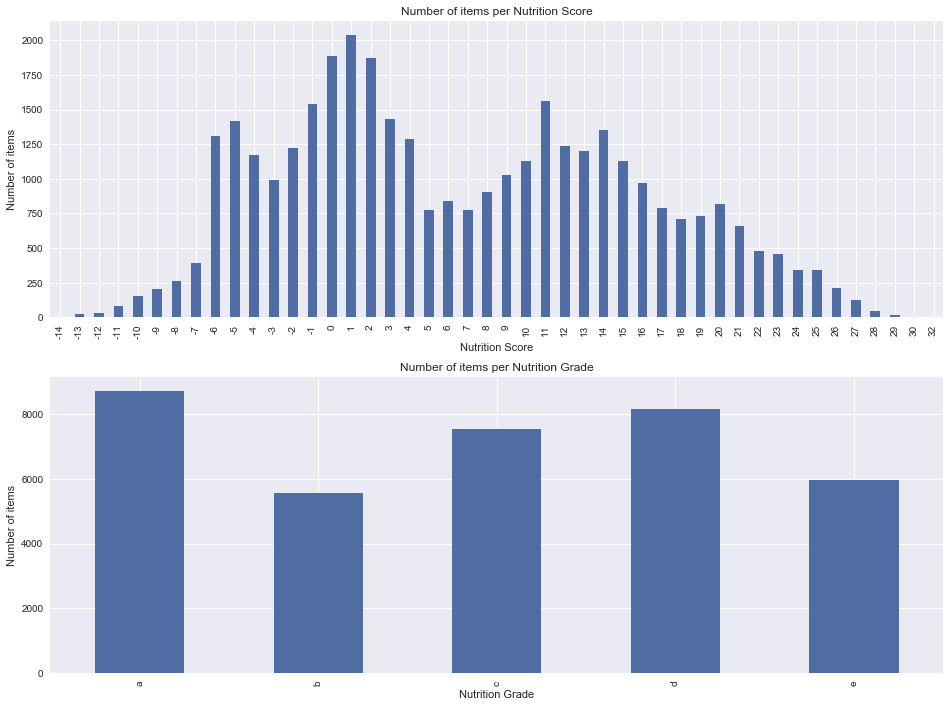

In [117]:
# Convert the score to an integer value
df_corr['nutrition-score-fr_100g'] = df_corr['nutrition-score-fr_100g'].astype(int)

# Plot the number of items per score and grade
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(16, 12))
df_corr.groupby('nutrition-score-fr_100g').size().plot.bar(ax=ax1, color='#4f6ca3')
df_corr.groupby('nutrition_grade_fr').size().plot.bar(ax=ax2, color='#4f6ca3')
ax1.set_xlabel('Nutrition Score')
ax2.set_xlabel('Nutrition Grade')
ax1.set_ylabel('Number of items')
ax2.set_ylabel('Number of items')
ax1.set_title('Number of items per Nutrition Score')
ax2.set_title('Number of items per Nutrition Grade')
plt.show()

Scores and grades seems to be directly related but no sure, let's look at the range of scores we have per grade :

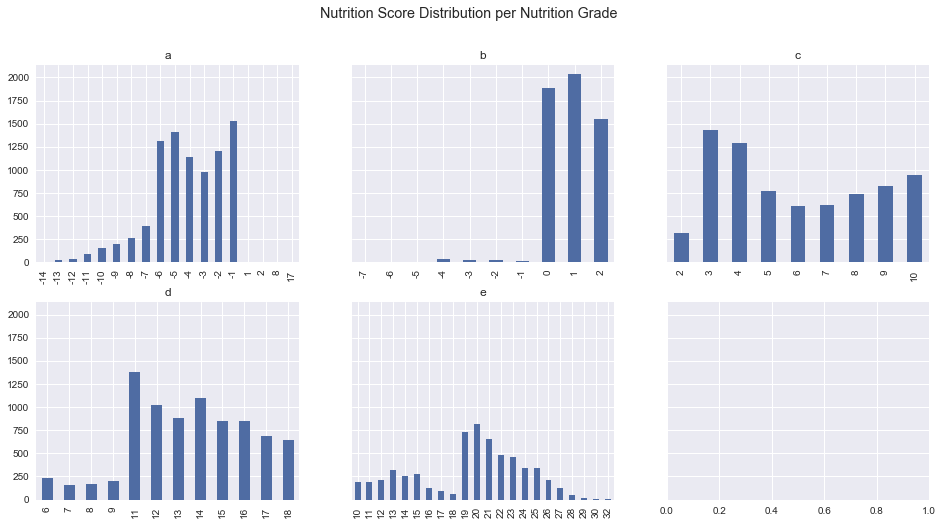

In [118]:
# Show score distributions per grade
grades = ['a', 'b', 'c', 'd', 'e']
fig, ax = plt.subplots(nrows=2, ncols=3, sharey=True, figsize=(16, 8))

i = 0
for grade in grades:
    row = i // 3
    col = i % 3
    df_corr[df_corr.nutrition_grade_fr == grade].groupby('nutrition-score-fr_100g').size().plot.bar(ax=ax[row, col], color='#4f6ca3')
    ax[row, col].set_title(grade)
    ax[row, col].set_xlabel('')
    i += 1
 
plt.suptitle('Nutrition Score Distribution per Nutrition Grade')
plt.show()

Even if the are some overlap for unknown reason, the nutrition grades are related to nutrition score :

- A corresponds to score from -14 to -1 (greater scores are probably misclassified data)
- B corresponds to score from -4 to 2 (but essentially from 0 to 2, are negative score also misclassified products ?)
- C corresponds to score from 2 to 10
- D corresponds to score from 6 to 18
- E corresponds to score from 10 to 32

We can see that lower is the score better is the grade. Let's investigate about the overlap and look at which kind of products are included in these overlaps :

In [119]:
# Get food categories for food with grade B and score lower than 0
get_top_occurencies(df_corr.loc[(df_corr.nutrition_grade_fr == 'b') & (df_corr['nutrition-score-fr_100g'] < 0)], 'pnns_groups_2')

,count,count %
pnns_groups_2,,
Fruit juices,54,52.43
Non sugared beverages,45,43.69
Artificially sweetened beverages,3,2.91
Sweetened beverages,1,0.97


In [120]:
# Get food categories for food with grade D and score lower than 11
get_top_occurencies(df_corr.loc[(df_corr.nutrition_grade_fr == 'd') & (df_corr['nutrition-score-fr_100g'] < 11)], 'pnns_groups_2')

,count,count %
pnns_groups_2,,
Non sugared beverages,346,45.89
Sweetened beverages,190,25.20
Fruit juices,163,21.62
Artificially sweetened beverages,35,4.64
Fruit nectars,20,2.65


In [121]:
# Get food categories for food with grade E and score lower than 19
get_top_occurencies(df_corr.loc[(df_corr.nutrition_grade_fr == 'e') & (df_corr['nutrition-score-fr_100g'] < 19)], 'pnns_groups_2')

,count,count %
pnns_groups_2,,
Non sugared beverages,816,47.41
Sweetened beverages,705,40.96
Fruit nectars,139,8.08
Fruit juices,40,2.32
Artificially sweetened beverages,21,1.22


Interesting, it appears that the overlaps correspond to beverage. It probably means that the grade attribution thresholds are different for food and beverages. 

### Nutrition Score by PNNS Groups

Here we will compare the nutrition score statistics for different kind of food :

In [122]:
# Reminder and for easier consultation, show the mean macronutrients composition per kind of food
means_by_pnns

energy_100g  \
pnns_groups_1           pnns_groups_2                                   
Beverages               Artificially sweetened beverages    56.377810   
                        Fruit juices                       196.035229   
                        Fruit nectars                      189.943529   
                        Non sugared beverages              160.841892   
                        Sweetened beverages                306.805876   
Cereals and potatoes    Bread                             1306.306064   
                        Breakfast cereals                 1693.883077   
                        Cereals                           1336.043422   
                        Legumes                            956.855552   
                        Potatoes                           472.808824   
Composite foods         One dish meals                     547.010611   
                        Pizza pies and quiche              972.031073   
                        Sandwich                           992.279891   
Fat and sauces          Dressings and sauces               781.174117   
                        Fats                              3118.753450   
Fish meat eggs          Eggs                               596.475758   
                        Fish and seafood                   702.744191   
                        Meat                               690.675787   
                        Processed meat                     964.297098   
Fruits and vegetables   Dried fruits                      1422.064589   
                        Fruits                             295.033223   
                        Soups                              165.879012   
                        Vegetables                         186.887891   
Milk and dairy products Cheese                            1159.189800   
                        Dairy desserts                     630.883295   
                        Ice cream                          906.520396   
                        Milk and yogurt                    346.014994   
Salty snacks            Appetizers                        2068.845895   
                        Nuts                              2584.627160   
Sugary snacks           Biscuits and cakes                1909.996136   
                        Chocolate products                2165.175709   
                        Pastries                          1531.497872   
                        Sweets                            1423.529279   

                                                          carbohydrates_100g  \
pnns_groups_1           pnns_groups_2                                          
Beverages               Artificially sweetened beverages            2.914947   
                        Fruit juices                               10.639178   
                        Fruit nectars                              10.754941   
                        Non sugared beverages                       7.523576   
                        Sweetened beverages                        16.728510   
Cereals and potatoes    Bread                                      55.205164   
                        Breakfast cereals                          68.743140   
                        Cereals                                    60.150583   
                        Legumes                                    19.432816   
                        Potatoes                                   17.013676   
Composite foods         One dish meals                             12.059929   
                        Pizza pies and quiche                      25.302345   
                        Sandwich                                   24.208098   
Fat and sauces          Dressings and sauces                       11.938731   
                        Fats                                        0.853287   
Fish meat eggs          Eggs                                        0.727446   
                        Fish and seafood                      

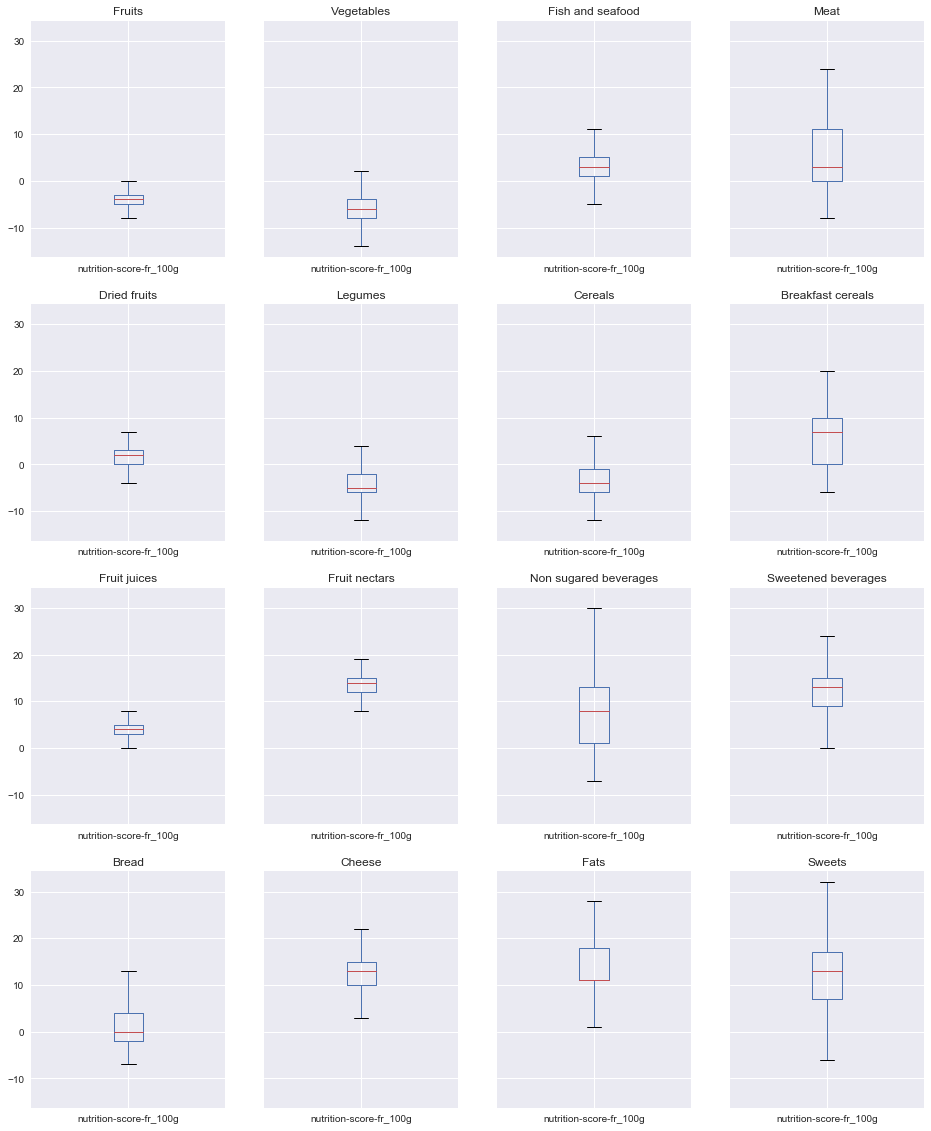

In [123]:
# Look at the nutrition score statistics for different food categories
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(16, 20), sharey=True)


foods = ['Fruits', 'Vegetables', 'Fish and seafood', 'Meat', 
         'Dried fruits', 'Legumes', 'Cereals', 'Breakfast cereals',
         'Fruit juices', 'Fruit nectars', 'Non sugared beverages', 'Sweetened beverages',
         'Bread', 'Cheese', 'Fats', 'Sweets']

i = 0
for food in foods:
    row = i // 4
    col = i % 4
    df_corr.loc[df_corr.pnns_groups_2 == food, 'nutrition-score-fr_100g'].plot.box(ax=ax[row, col])
    ax[row, col].set_title(food)
    i += 1

plt.show()

Quartiles for fruits, vegetables, legumes and cereals are negative scores. It confirms that lower scores correspond to better food and our mums were rights when asking us to eat all our vegetables :)

From the different boxplots and the nutrient composition by category of food obtained previously, it seems reasonable to think that sugars (non sugared vs sweetened beverages, cereal vs breakfast cereals) and fats (cheese, fats) have negative impact on the score. 

The variance for bread is interesting, it is definitvely important to make the right choise for our sandwich ! And fruit nectars are not so good, it's misleading... Note that even if on average, fish and seafood and meat have the same nutrients composition ratio, the variance for meat is much greater. 

As a simple rule of thumb, eating fruits, vegetables, legumes, cereals and fish and seafood seems a good diet.

### Nutrition Score vs Energy, Fiber & Salt

Let's now investigate about potential correlation between the nutrition score and the different variables. Here we start with energy, fiber and salt :

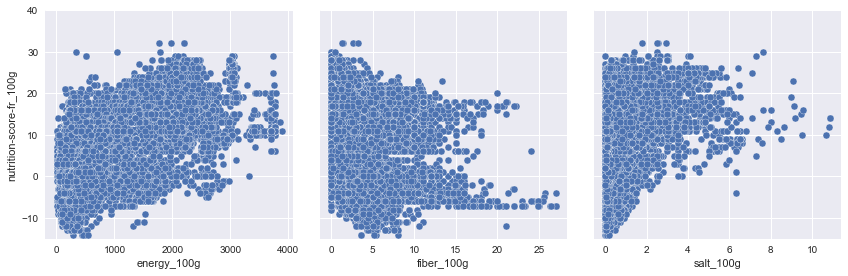

In [124]:
x_vars = [
    'energy_100g',
    'fiber_100g',
    'salt_100g']

y_vars = ['nutrition-score-fr_100g']

g = sns.pairplot(df_corr, kind='scatter', x_vars=x_vars, y_vars=y_vars, size=4)
g.set(ylim=(-15, 40))
plt.show()

By looking at the empty spaces and the pointing direction of the clouds of points, it appears that :

- Energy has a negative impact on the nutrition score (positive correlation)
- Salt has a negative impact on the nutrition score (positive correlation)
- Fiber has a positive impact on the nutrition score (negative correlation)

### Nutrition Score vs Carbohydrates & breakdown

Because there are a positive correlation with energy and we know that carbohydrates contribute to energy (4kcal per gram), we can expect to also observe a positive correlation between nutrition score and carbohydrates. Here, we also look at the correlation with the carbohydrates first level breakdown (sugars, polyols and starch) : 

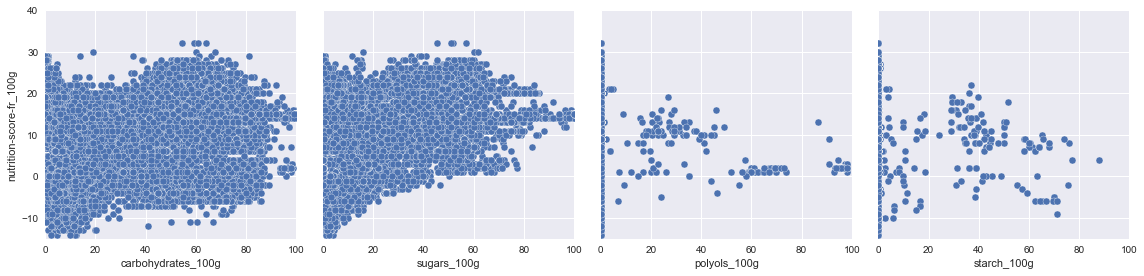

In [125]:
x_vars = [
    'carbohydrates_100g',
    'sugars_100g',
    'polyols_100g',
    'starch_100g']

y_vars = ['nutrition-score-fr_100g']

g = sns.pairplot(df_corr, kind='scatter', x_vars=x_vars, y_vars=y_vars, size=4)
g.set(xlim=(0, 100))
g.set(ylim=(-15, 40))
plt.show()

Surprisingly, it is not the carbohydrates composition that influence the most the score but the sugars proportion. Carbohydrates are not all equal...  
Apparently there is no correlation with polyols and starch.

### Nutrition Score vs Fats & breakdown

Same idea here but for the fats. We expect to find a positive correlation between score and fact (8kcal per gram of fat). We also look at correlation with the fat first level breakdowns (saturated fat, monounsaturated fat, polyunsaturated fat, trans fat):


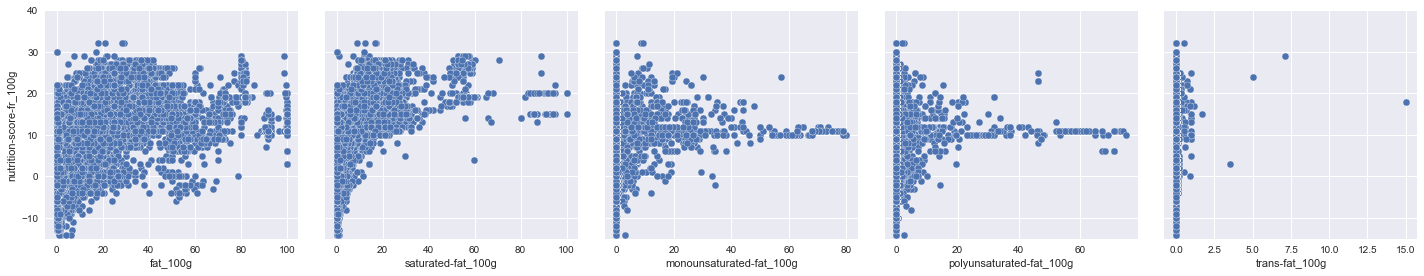

In [126]:
x_vars = [
    'fat_100g',
    'saturated-fat_100g',
    'monounsaturated-fat_100g',
    'polyunsaturated-fat_100g',
    'trans-fat_100g']

y_vars = ['nutrition-score-fr_100g']

g = sns.pairplot(df_corr, kind='scatter', x_vars=x_vars, y_vars=y_vars, size=4)
g.set(ylim=(-15, 40))
plt.show()

Here also, we can see that fats have a negative impact on score but the correlation is even stronger for saturated fats. From mono and poly unsaturated fats, there is no visible correlation but it is interesting to see that the mean score is 10 and near constant, specially as the weight of unsaturated fats grows. Oils are at the right edge of these plots and are composed essentially of fats. It's like pure fat products would be capped at a score of ten...

### Nutrition Score vs Proteins & breakdown

Let's do the same for proteins and its first level breakdown :

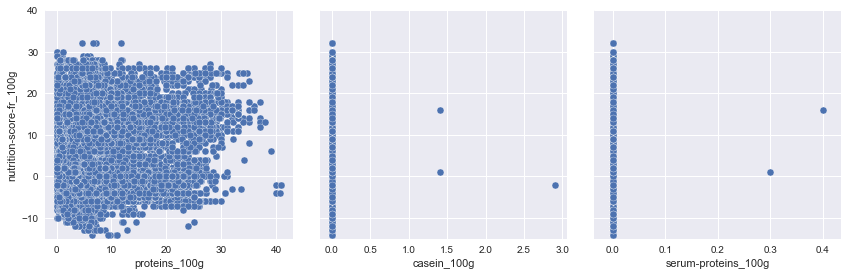

In [127]:
x_vars = [
    'proteins_100g',
    'casein_100g',
    'serum-proteins_100g']

y_vars = ['nutrition-score-fr_100g']

g = sns.pairplot(df_corr, kind='scatter', x_vars=x_vars, y_vars=y_vars, size=4)
g.set(ylim=(-15, 40))
plt.show()

We don't see correlation between the nutrition score and proteins weight and we don't have enough data for casein and serum proteins to speak about them. When we tried to find the energy contribution of each macronutrients, it was not possible to isolate food with a lot of proteins but few carbohydrates and fats. Here also, the potential proteins correlation is maybe flooded by the effect of the other macronutrients.

Let's see if we can find some correlation for different kind of food :

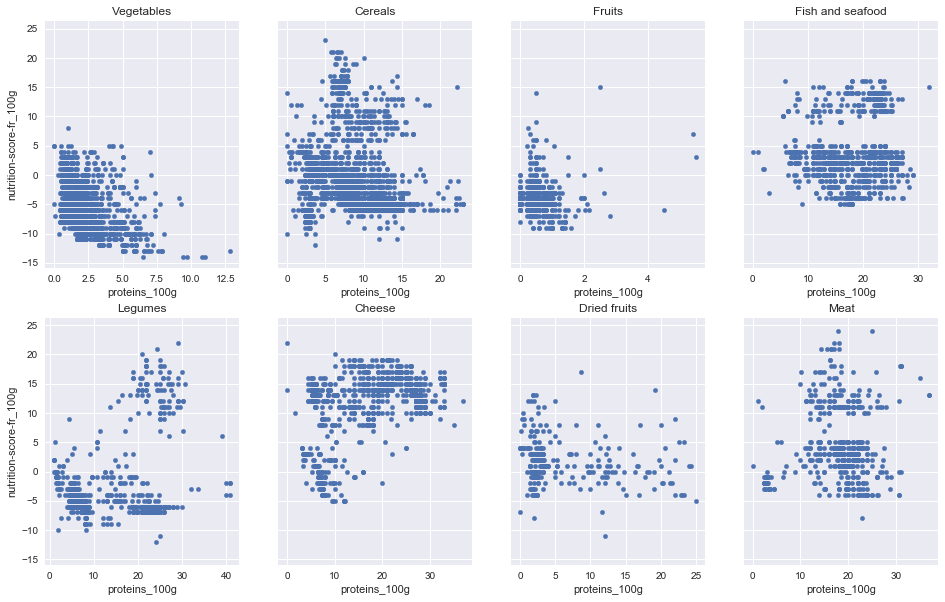

In [128]:
foods = ['Vegetables', 'Cereals', 'Fruits', 'Fish and seafood',
         'Legumes', 'Cheese', 'Dried fruits', 'Meat']

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 10), sharey=True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

i = 0
for food in foods:
    row = i // 4
    col = i % 4
    df_corr[df_corr.pnns_groups_2 == food].plot(ax=ax[row, col], 
                                                x='proteins_100g', 
                                                y='nutrition-score-fr_100g', 
                                                kind='scatter')
    ax[row, col].set_title(food)
    i += 1

Except for vegetables, fruits and cereals for which we could say that proteins have a positive impact on the score (negative correlation), we clearly don't observe the same pattern for the other kind of food. In fact, we even observe no correlation at all with these spreaded flat clouds...

We already see with the box plots that vegetables, fruits and cereals have very good nutrition scores. It's like if proteins were part of the score calculation only for vegetables, fruits and cereals (maybe also other not ploted food categories...).

We saw that the nutrition grade is computed differently for food and beverages. It seems possible that the score is also computed differently for various kind of food. Overall, if proteins have an impact on the score, it's positively (negative correlation if some condition (food category) are met).

### Summary

In summary, the nutrition food score is a discrete value from -15 to 40, lower is better. Vegetables, fruits, cereals, legumes are the only food categories with negative scores (all quartiles are negative). We find correlation between the score and the following variables :

- Energy has a negative impact (positive correlation)
- Sugars have a negative impact (positive correlation)
- Saturated fats have a negative impact (positive correlation)
- Salt has a negative impact (positive correlation)
- Fibers have a positive impact (negative correlation)
- Proteins have positive impact (negative correlation) but the correlation seems to exist only for some kind of food (fruits, vegetable, cereals, maybe others also). For some other kinds of food, there are absolutely no correlation at all.

The nutrition score is probably not a simple mathematic formula but more a scoring system which attribute points according to some conditions and thresholds, that could be different according to the kind of food as it is the case for the grades with beverages and foods.